In [1]:
#Different libraries that we need 

import numpy as np # numerical python for operations on arrays, matrix
import pandas as pd # very efficient for handling databases 
import matplotlib.pyplot as plt # for plots 
import glob # for accessing directories (where the data are)
from scipy import stats # scientific python - for special functions and probability densities 
import re # for regular expressions 
from tqdm import tqdm_notebook as tqdm 
import matplotlib.image as mpimg # Importing images for visualization and learning curves comparison (with/without outliers)
import scipy.optimize as opt # curve fitting 
import matplotlib.patches as patches # Active zones
import matplotlib.path as mplPath
import os

# in order to plot inline, Jupyter Notebook only 
%matplotlib notebook 


## My functions 

In [2]:
# Find Outliers -- upper and lower limit to 3 std 

def find_outliers(random_data):
    anomalies = []
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(random_data)
    random_data_mean = np.mean(random_data)
    anomaly_cut_off = random_data_std *3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    # Generate outliers
    for outlier in random_data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies

In [3]:
# Constants -- difference between mask area and landmark area 
area_small_square = (8.6*8.6 - 5.6 * 5.6) /10000 # side = 5.6 cm 
area_large_square = (12*12 - 9 *9)/10000 # side = 9 cm 
area_small_circle = np.pi *(6.8*6.8 - 3.8*3.8)/10000 # radius = 3.8 cm 
area_large_circle = np.pi *(8.1*8.1 -  5.1 * 5.1)/10000 # radius = 5.1 cm 
area_small_triangle = (np.sqrt(3)/4) *(10.2*10.2 -  7.2*7.2)/10000 # side = 7.2 cm , equilater triangle, area from side (bc h = sqrt(3)/2 * side)
area_large_triangle = (np.sqrt(3)/4) *(16.2*16.2 - 13.2*13.2)/10000 # side = 13.2 cm 

area_food = np.pi * 4*4/10000 # 4 cm 

## Importing Data from .csv files

In [4]:
# Import all the .csv files 
trackFiles = []
trackFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleCsv/Track/*.csv')

shapeFiles = []
shapeFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleCsv/Shapes/*.csv')

relationsFiles = []
relationsFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleCsv/NewRelationsFiles/*.csv')

probeFilteredTrackFiles = []
probeFilteredTrackFiles = glob.glob(r"C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleFirstEncounterProbeCsv/Track/*.csv")

probeFilteredShapesFiles = []
probeFilteredShapesFiles = glob.glob(r"C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleFirstEncounterProbeCsv/Shapes/*.csv")


probeFilteredRelationsFiles = []
probeFilteredRelationsFiles = glob.glob(r"C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleFirstEncounterProbeCsv/Relations/*.csv")



#relation_new_files = []
#relation_new_files = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleCsv/NewRelationsFiles/*.csv')

In [5]:
probeFiles = []

# Filtering probe trials 
# if probeFilter = True, probetrials are not used in the future statistics
# if probeFilter = False, probetrials are going to take part in the stats
probeFilter = True 

if probeFilter == True:
    regExpr = re.compile(r'p_Track')
    regExpr2 = re.compile(r'p_shape')
    regExpr3 = re.compile(r'p_relations')
    
    probeFiles = list(filter(lambda i : regExpr.search(i), trackFiles))
    probeShapesFiles = list(filter(lambda i : regExpr2.search(i), shapeFiles))
    probeRelationsFiles = list(filter(lambda i : regExpr3.search(i), relationsFiles))
    
    trackFiles = list(filter(lambda i : not regExpr.search(i), trackFiles))
    shapeFiles = list(filter(lambda i : not regExpr2.search(i), shapeFiles))
    relationsFiles = list(filter(lambda i : not regExpr3.search(i), relationsFiles))
    
    
else : 
    trackFiles = trackFiles 
    shapeFiles = shapeFiles
    relationsFiles = relationsFiles 


In [6]:
# Creating list of tracking Data as list of pandas dataframes 
trackData = []
for i in tqdm(range(0,len(trackFiles))) : 
    trackData.append(pd.read_csv(trackFiles[i], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
    """_Track.csv files:
    Columns: T(s), X(m), Y(m), A(deg), R(Hz), D(m), V(m/s), S(m):
    T: camera frame time
    X: x coordinate of the head tip @ grid frame of reference
    Y: y coordinate of the head tip @ grid frame of reference
    A: head orientation
    R: EOD rate
    D: Distance per EOD pulse (=1/sampling_density)
    V: Head speed (m/s, signed)
    S: Distance per Escan (=1/escan_density)"""
    

#Adding landmark name and color in order to create a new dataframe for shapes

landm_name = {'Shape': ['Triangle Lg', 'Triangle Sm',  'Square Lg', 'Square Sm', 'Circle Lg', 'Circle Sm', 'Food']} 
shape_names = pd.DataFrame(data = landm_name)

color_shapes = pd.DataFrame(data = np.linspace(0,1,7), columns= ['Color'])

shapeData = []
for i in tqdm(range(0,len(shapeFiles))) : 
    shapeData.append(pd.read_csv(shapeFiles[i], names = ["X", "Y", "Angle"]))
    shapeData[i] = pd.concat([shape_names,shapeData[i]], axis = 1)
    shapeData[i] = pd.concat([shapeData[i], color_shapes], axis = 1)
    
    """_shapes.csv files:
    Columns: X(m), Y(m), A(deg):
    X(m): x coordinate of the shape center @ grid frame of reference
    Y(m): y coordinate of the shape center @ grid frame of reference
    A(deg): Shape orientation
    Rows: "Triangle Lg", "Triangle Sm", "Square Lg", "Square Sm", "Circle Lg", "Circle Sm", "Food", """
    
    
relationsData = []
for i in tqdm(range(0,len(relationsFiles))) : 
    relationsData.append(pd.read_csv(relationsFiles[i]).drop(columns = ['Unnamed: 0']))

    """_relations.csv files:
       Columns: T(s), D_F(m), A_E(deg), L_"Triangle Lg"(bool), L_"Triangle Sm"(bool), L_"Square Lg"(bool), L_"Square Sm"(bool), L_"Circle Lg"(bool), L_"Circle Sm"(bool), L_"Food"(bool), 
       T: camera frame time
       D_F: distance to the food
       A_E: heading angle error (food_vec - head_vec, 0..90 deg)
       L_"x": Is shape "x" adjacent to the head position? 0:no, 1:yes"""

# Creating list of probe Data as list of pandas dataframes 
probeData = []
for i in tqdm(range(0,len(probeFilteredTrackFiles))) : 
    probeData.append(pd.read_csv(probeFilteredTrackFiles[i], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"], skiprows = 1))

probeShapeData = []
for i in tqdm(range(0,len(probeFilteredShapesFiles))) : 
    probeShapeData.append(pd.read_csv(probeFilteredShapesFiles[i], names = ["X", "Y", "Angle"]))
    probeShapeData[i] = pd.concat([shape_names,probeShapeData[i]], axis = 1)
    probeShapeData[i] = pd.concat([probeShapeData[i], color_shapes], axis = 1)

probeRelationsData = [] 
for i in tqdm(range(0,len(probeFilteredRelationsFiles))) : 
    probeRelationsData.append(pd.read_csv(probeFilteredRelationsFiles[i], names = ["CameraFrameTime", "DistFood", "HeadAngleError", 
                                                                 "ActiveZoneTriangleLarge", "ActiveZoneTriangleSmall", "ActiveZoneSquareLarge", "ActiveZoneSquareSmall", "ActiveZoneCircleLarge"
                                                                , "ActiveZoneCircleSmall", "ActiveZoneFood"], skiprows = 1))
    


In [7]:
#Quick consistency check 
len(trackData) == len(shapeData) ==len(relationsData)

True

## Plotting example trajectory

In [8]:
df_for_sampling_density_analysis = []

for i in tqdm(range(0,len(trackFiles))) :
    df_for_sampling_density_analysis.append(pd.concat([trackData[i]['Time'],
                                                       trackData[i]['X'], trackData[i]['Y'],trackData[i]['DistanceXEODPulse'], relationsData[i]['ActiveZoneTriangleLarge'],
                                                        relationsData[i]['ActiveZoneTriangleSmall'], relationsData[i]['ActiveZoneSquareLarge'], relationsData[i]['ActiveZoneSquareSmall'],relationsData[i]['ActiveZoneCircleLarge'],
                                                       relationsData[i]['ActiveZoneCircleSmall'], relationsData[i]['ActiveZoneFood']], axis=1, keys=['Time', 'X', 'Y', 'SamplingDensity','ActiveZoneTriangleLarge', 'ActiveZoneTriangleSmall', 'ActiveZoneSquareLarge', 'ActiveZoneSquareSmall' ,'ActiveZoneCircleLarge', 'ActiveZoneCircleSmall', 'ActiveZoneFood']))
    df_for_sampling_density_analysis[i] = df_for_sampling_density_analysis[i].replace([np.inf,-np.inf], 0)
   
    #df_for_sampling_density_analysis[i]['SamplingDensity'] = (df_for_sampling_density_analysis[i]['SamplingDensity'] - df_for_sampling_density_analysis[i]['SamplingDensity'].min() )/(df_for_sampling_density_analysis[i]['SamplingDensity'].max() - df_for_sampling_density_analysis[i]['SamplingDensity'].min())

In [9]:
df_for_sampling_density_analysis_probe = []

for i in tqdm(range(0,len(probeFilteredTrackFiles))) :
    df_for_sampling_density_analysis_probe.append(pd.concat([probeData[i]['Time'],
                                                       probeData[i]['X'], probeData[i]['Y'], probeData[i]['DistanceXEODPulse'], probeRelationsData[i]['ActiveZoneTriangleLarge'],
                                                        probeRelationsData[i]['ActiveZoneTriangleSmall'], probeRelationsData[i]['ActiveZoneSquareLarge'], probeRelationsData[i]['ActiveZoneSquareSmall'], probeRelationsData[i]['ActiveZoneCircleLarge'],
                                                        probeRelationsData[i]['ActiveZoneCircleSmall'], probeRelationsData[i]['ActiveZoneFood']], axis=1, keys=['Time', 'X', 'Y', 'SamplingDensity','ActiveZoneTriangleLarge', 'ActiveZoneTriangleSmall', 'ActiveZoneSquareLarge', 'ActiveZoneSquareSmall' ,'ActiveZoneCircleLarge', 'ActiveZoneCircleSmall', 'ActiveZoneFood']))
    df_for_sampling_density_analysis_probe[i] = df_for_sampling_density_analysis_probe[i].replace([np.inf,-np.inf], 0)
    df_for_sampling_density_analysis_probe[i] = df_for_sampling_density_analysis_probe[i].dropna()
    #df_for_sampling_density_analysis[i]['SamplingDensity'] = (df_for_sampling_density_analysis[i]['SamplingDensity'] - df_for_sampling_density_analysis[i]['SamplingDensity'].min() )/(df_for_sampling_density_analysis[i]['SamplingDensity'].max() - df_for_sampling_density_analysis[i]['SamplingDensity'].min())

<IPython.core.display.Javascript object>


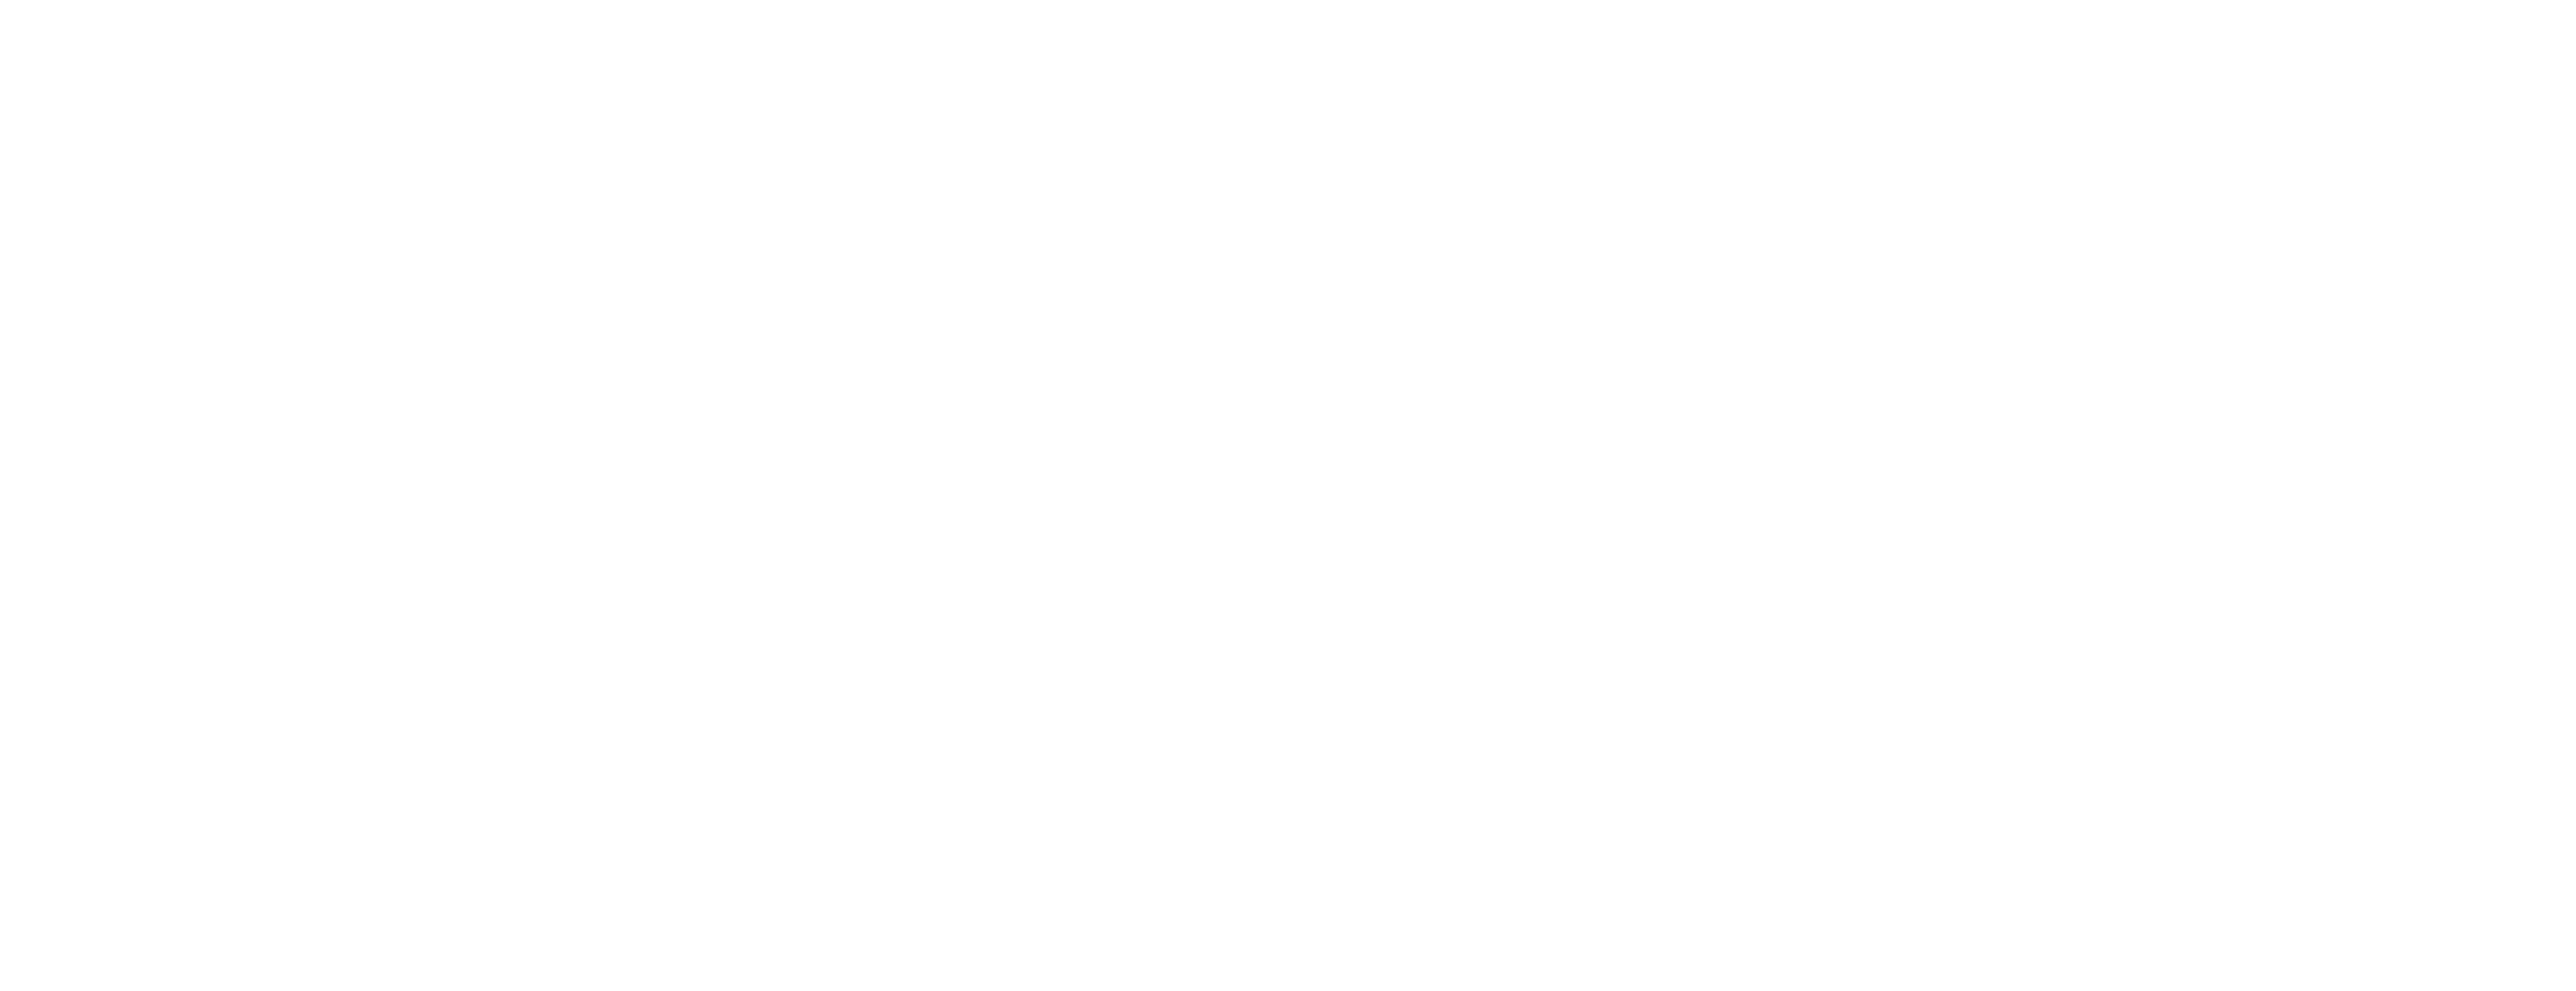

In [10]:
%matplotlib notebook 

#Select trajectory number (based on number of videos = 199 + 14(probes))
traj_number = 300

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (26,10))

circ = patches.Circle((0, 0), 0.9, alpha=0.10, fc='grey')
square = patches.Rectangle((-0.5,-0.5), 1, 1, alpha = 0.15, fc = 'yellow')
circ2 = patches.Circle((0, 0), 0.08, alpha=0.20, fc='red')

circ1 = patches.Circle((0, 0), 0.9, alpha=0.10, fc='grey')
square1 = patches.Rectangle((-0.5,-0.5), 1, 1, alpha = 0.15, fc = 'yellow')
circ12 = patches.Circle((0, 0), 0.08, alpha=0.20, fc='red')


ax1.add_patch(circ)
ax1.add_patch(square)
ax1.add_patch(circ2)

ax2.add_patch(circ1)
ax2.add_patch(square1)
ax2.add_patch(circ12)

 
plt.grid()
plt.xlim(-1,1)
plt.ylim(-1,1)

shapeData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax1, marker = 's', s = 30,style = 'o', label = 'Landmarks', c = 'Color', cmap = 'Spectral_r', alpha =1)
df_for_sampling_density_analysis[traj_number].plot.scatter(x = "X", y = "Y", ax = ax1, c = "SamplingDensity",  cmap = 'Spectral', alpha = 1)

df_for_sampling_density_analysis[traj_number].plot.line(x = "X", y = 'Y', ax = ax1, style = 'b', alpha = 0.2, grid = True, label = 'Trajectory')

# Setting positions of landmarks and trajectory points 
shapeData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax2, marker = 's', s = 30, style = 'o', label = 'Landmarks', c = 'Color', cmap = 'Spectral_r', alpha =1)
trackData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax2,c = 'Time', cmap = 'Spectral_r')

# Adding polygonal chain in order to see the trajectory and get vector length later 
trackData[traj_number].plot.line(x = "X", y = 'Y', ax = ax2, style = 'b', alpha = 0.5, grid = True, label = 'Trajectory')


plt.Axes.autoscale(ax1)
plt.Axes.autoscale(ax2)

<IPython.core.display.Javascript object>


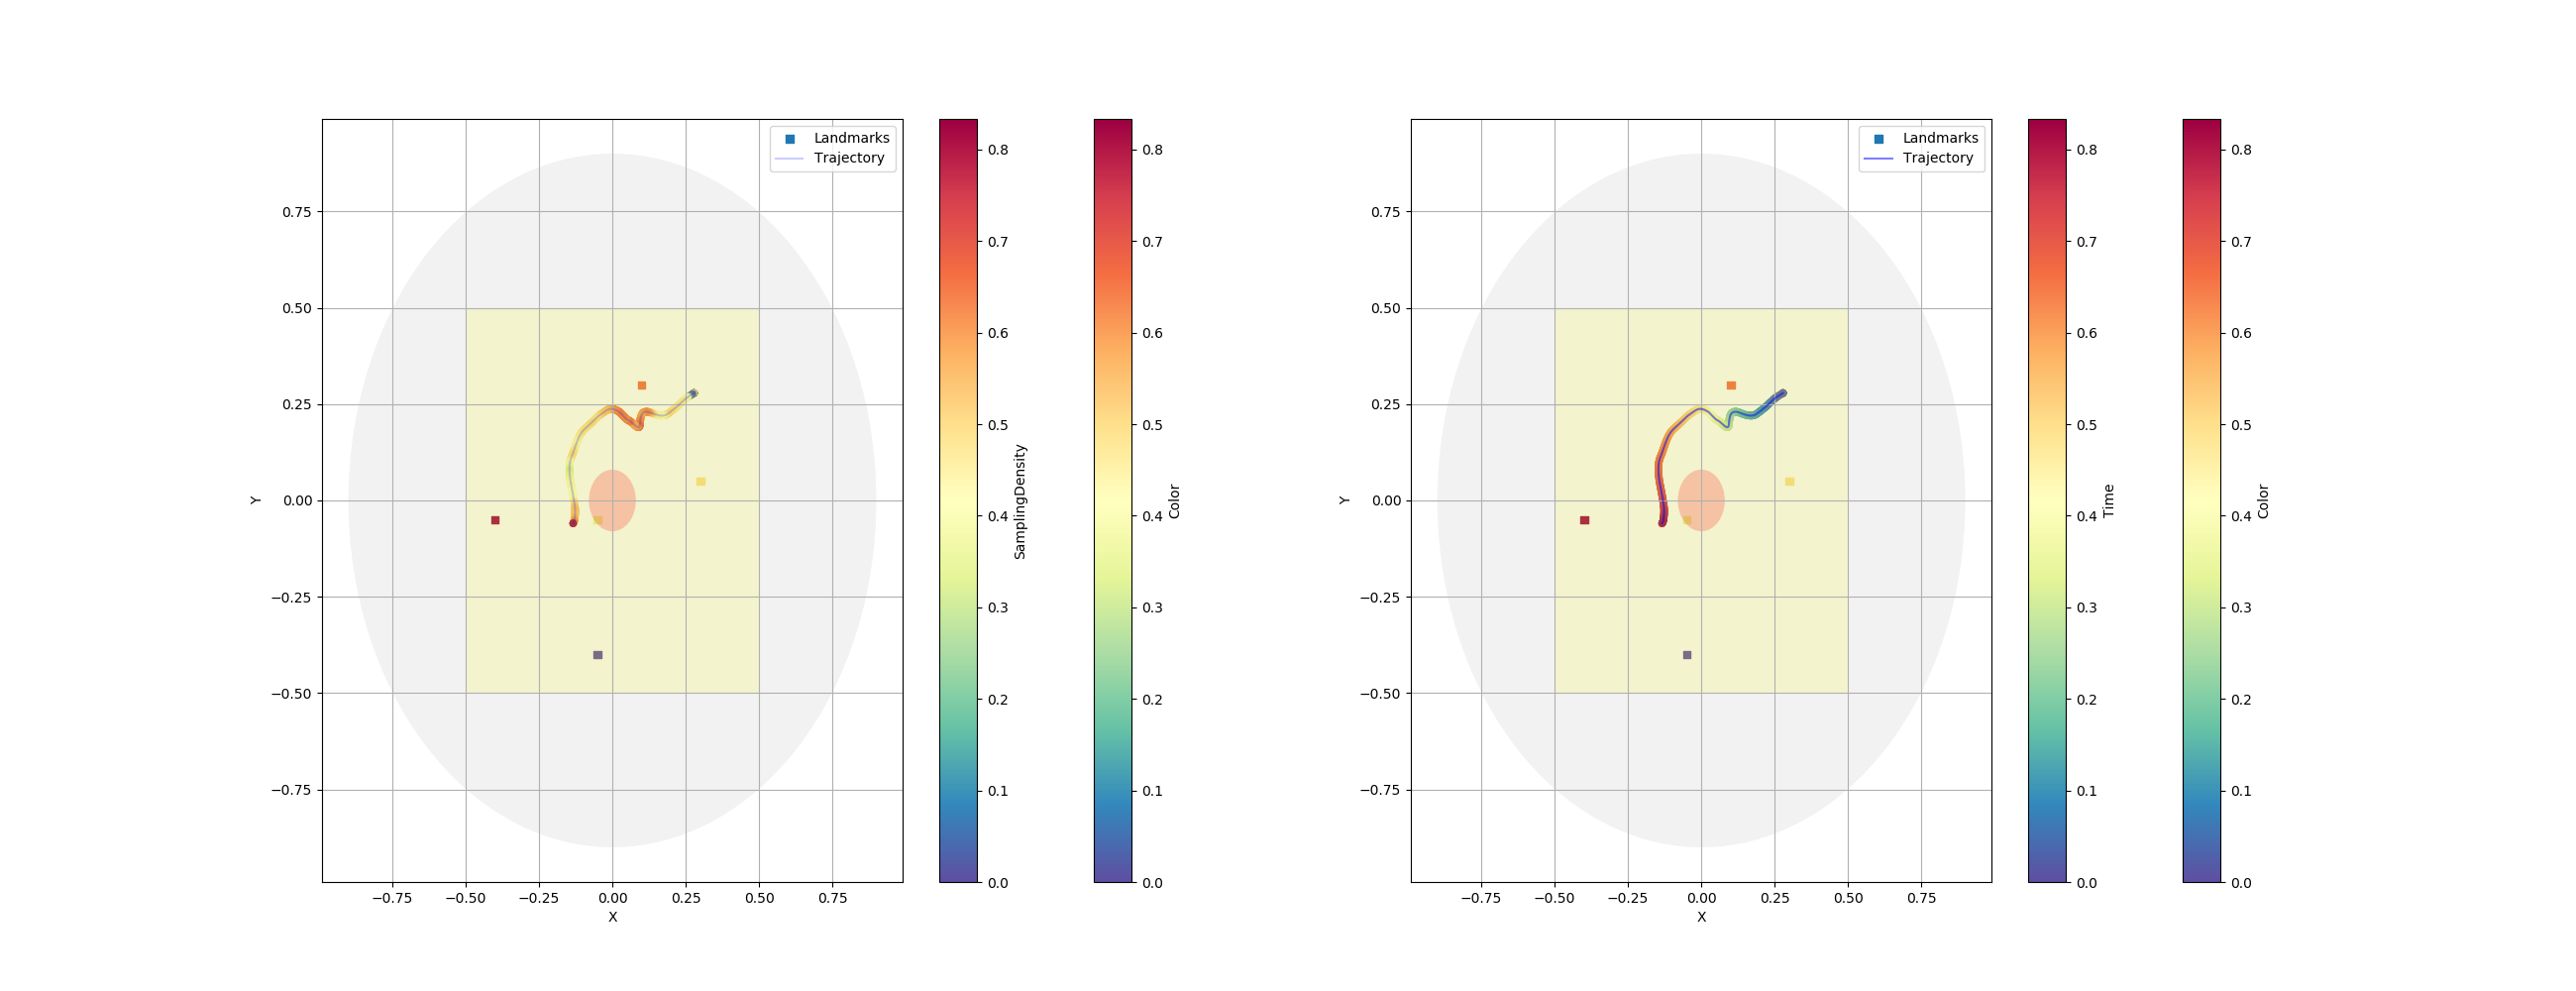

In [11]:
%matplotlib notebook 

#Select trajectory number (based on number of videos = 199 + 14(probes))
traj_number = 6

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (26,10))

circ = patches.Circle((0, 0), 0.9, alpha=0.10, fc='grey')
square = patches.Rectangle((-0.5,-0.5), 1, 1, alpha = 0.15, fc = 'yellow')
circ2 = patches.Circle((0, 0), 0.08, alpha=0.20, fc='red')

circ1 = patches.Circle((0, 0), 0.9, alpha=0.10, fc='grey')
square1 = patches.Rectangle((-0.5,-0.5), 1, 1, alpha = 0.15, fc = 'yellow')
circ12 = patches.Circle((0, 0), 0.08, alpha=0.20, fc='red')


ax1.add_patch(circ)
ax1.add_patch(square)
ax1.add_patch(circ2)

ax2.add_patch(circ1)
ax2.add_patch(square1)
ax2.add_patch(circ12)

 
plt.grid()
plt.xlim(-1,1)
plt.ylim(-1,1)

probeShapeData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax1, marker = 's', s = 30,style = 'o', label = 'Landmarks', c = 'Color', cmap = 'Spectral_r', alpha =1)
df_for_sampling_density_analysis_probe[traj_number].plot.scatter(x = "X", y = "Y", ax = ax1, c = "SamplingDensity",  cmap = 'Spectral', alpha = 1)

df_for_sampling_density_analysis_probe[traj_number].plot.line(x = "X", y = 'Y', ax = ax1, style = 'b', alpha = 0.2, grid = True, label = 'Trajectory')

# Setting positions of landmarks and trajectory points 
probeShapeData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax2, marker = 's', s = 30, style = 'o', label = 'Landmarks', c = 'Color', cmap = 'Spectral_r', alpha =1)
probeData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax2,c = 'Time', cmap = 'Spectral_r')

# Adding polygonal chain in order to see the trajectory and get vector length later 
probeData[traj_number].plot.line(x = "X", y = 'Y', ax = ax2, style = 'b', alpha = 0.5, grid = True, label = 'Trajectory')


plt.Axes.autoscale(ax1)
plt.Axes.autoscale(ax2)

## Check food associated shape by finding the closest landmark to food 
Apparently there's an issue regarding Fish C and Fish D, their food-related landmark is not fixed (there isn't only one shape associated to food, WEIRD ask LEN) 

In [12]:
# Check food associated shape by finding the closest landmark to food 
def euclidean_distance(x1, y1, x2, y2): 
    dist = np.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))
    return dist 

In [13]:
# Create new shape Data with euclidian distance from food 
# RUN IT ONCE 

for i in tqdm(range(0, len(shapeData))):
    pivotList = []
    
    for index, row in shapeData[i].iterrows():
    
        pivotList.append(euclidean_distance(shapeData[i].iloc[6, 1], shapeData[i].iloc[6, 2], row['X'], row['Y']))
    
    pivotArray = np.asarray(pivotList)   
    shapeData[i]['EuclidianDistanceFood'] = pivotArray


## Divide Data in 4 different groups (one for each fish) 

In [14]:
indexFishA = []
indexFishB = [] 
indexFishC = [] 
indexFishD = [] 

for i in range(0,len(trackFiles)):
    if trackFiles[i][-12] == 'A':
        indexFishA.append(i)
        
    elif trackFiles[i][-12] == 'B':
        indexFishB.append(i)
        
    elif trackFiles[i][-12] == 'C':
        indexFishC.append(i)
        
    elif trackFiles[i][-12] == 'D':
        indexFishD.append(i)      

indexFishAProbe = []
indexFishBProbe = [] 
indexFishCProbe = [] 
indexFishDProbe = [] 

for i in range(0,len(probeFilteredTrackFiles)):
    if probeFilteredTrackFiles[i][-13] == 'A':
        indexFishAProbe.append(i)
        
    elif probeFilteredTrackFiles[i][-13] == 'B':
        indexFishBProbe.append(i)
        
    elif probeFilteredTrackFiles[i][-13] == 'C':
        indexFishCProbe.append(i)
        
    elif probeFilteredTrackFiles[i][-13] == 'D':
        indexFishDProbe.append(i)      

        

In [15]:
dataFishA = []
dataFishB = []
dataFishC = []
dataFishD = []

#for i in range(0, len(df_for_sampling_density_analysis)):cd
for j in indexFishA:
    dataFishA.append(df_for_sampling_density_analysis[j])
for j in indexFishB:
    dataFishB.append(df_for_sampling_density_analysis[j])
for j in indexFishC:
    dataFishC.append(df_for_sampling_density_analysis[j])
for j in indexFishD:
    dataFishD.append(df_for_sampling_density_analysis[j])
    
dataProbeFishA = []
dataProbeFishB = []
dataProbeFishC = []
dataProbeFishD = []

for j in indexFishAProbe:
    dataProbeFishA.append(df_for_sampling_density_analysis_probe[j])
for j in indexFishBProbe:
    dataProbeFishB.append(df_for_sampling_density_analysis_probe[j])
for j in indexFishCProbe:
    dataProbeFishC.append(df_for_sampling_density_analysis_probe[j])
for j in indexFishDProbe:
    dataProbeFishD.append(df_for_sampling_density_analysis_probe[j])
    

## Getting sub-dataframes for Food associated Shape and average among other shapes comparison

### Fish A - Square Lg (food associated) 

In [16]:
active_square_small_fishA = []
active_square_large_fishA = []
active_circle_small_fishA = []
active_circle_large_fishA = []
active_triangle_small_fishA = []
active_triangle_large_fishA = []
active_food_fishA = []

for i in tqdm(range(0,len(dataFishA))):
    active_square_large_fishA.append(dataFishA[i].loc[dataFishA[i]['ActiveZoneSquareLarge'] == 1])
    active_square_small_fishA.append(dataFishA[i].loc[dataFishA[i]['ActiveZoneSquareSmall'] == 1])
    active_circle_large_fishA.append(dataFishA[i].loc[dataFishA[i]['ActiveZoneCircleLarge'] == 1])
    active_circle_small_fishA.append(dataFishA[i].loc[dataFishA[i]['ActiveZoneCircleSmall'] == 1])
    active_triangle_large_fishA.append(dataFishA[i].loc[dataFishA[i]['ActiveZoneTriangleLarge'] == 1])
    active_triangle_small_fishA.append(dataFishA[i].loc[dataFishA[i]['ActiveZoneTriangleSmall'] == 1])
    active_food_fishA.append(dataFishA[i].loc[dataFishA[i]['ActiveZoneFood'] == 1])

### Fish A - Probe

In [17]:
active_square_small_fishA_probe = []
active_square_large_fishA_probe = []
active_circle_small_fishA_probe = []
active_circle_large_fishA_probe = []
active_triangle_small_fishA_probe = []
active_triangle_large_fishA_probe = []
active_food_fishA_probe = []

for i in tqdm(range(0,len(dataProbeFishA))):
    active_square_large_fishA_probe.append(dataProbeFishA[i].loc[dataProbeFishA[i]['ActiveZoneSquareLarge'] == 1])
    active_square_small_fishA_probe.append(dataProbeFishA[i].loc[dataProbeFishA[i]['ActiveZoneSquareSmall'] == 1])
    active_circle_large_fishA_probe.append(dataProbeFishA[i].loc[dataProbeFishA[i]['ActiveZoneCircleLarge'] == 1])
    active_circle_small_fishA_probe.append(dataProbeFishA[i].loc[dataProbeFishA[i]['ActiveZoneCircleSmall'] == 1])
    active_triangle_large_fishA_probe.append(dataProbeFishA[i].loc[dataProbeFishA[i]['ActiveZoneTriangleLarge'] == 1])
    active_triangle_small_fishA_probe.append(dataProbeFishA[i].loc[dataProbeFishA[i]['ActiveZoneTriangleSmall'] == 1])
    active_food_fishA_probe.append(dataProbeFishA[i].loc[dataProbeFishA[i]['ActiveZoneFood'] == 1])

### FishB - Circle Lg (food associated) 

In [18]:
active_square_small_fishB = []
active_square_large_fishB = []
active_circle_small_fishB = []
active_circle_large_fishB = []
active_triangle_small_fishB = []
active_triangle_large_fishB = []
active_food_fishB = []

for i in tqdm(range(0,len(dataFishB))):
    active_square_large_fishB.append(dataFishB[i].loc[dataFishB[i]['ActiveZoneSquareLarge'] == 1])
    active_square_small_fishB.append(dataFishB[i].loc[dataFishB[i]['ActiveZoneSquareSmall'] == 1])
    active_circle_large_fishB.append(dataFishB[i].loc[dataFishB[i]['ActiveZoneCircleLarge'] == 1])
    active_circle_small_fishB.append(dataFishB[i].loc[dataFishB[i]['ActiveZoneCircleSmall'] == 1])
    active_triangle_large_fishB.append(dataFishB[i].loc[dataFishB[i]['ActiveZoneTriangleLarge'] == 1])
    active_triangle_small_fishB.append(dataFishB[i].loc[dataFishB[i]['ActiveZoneTriangleSmall'] == 1])
    active_food_fishB.append(dataFishB[i].loc[dataFishB[i]['ActiveZoneFood'] == 1])

### Fish B - Probe

In [19]:
active_square_small_fishB_probe = []
active_square_large_fishB_probe = []
active_circle_small_fishB_probe = []
active_circle_large_fishB_probe = []
active_triangle_small_fishB_probe = []
active_triangle_large_fishB_probe = []
active_food_fishB_probe = []

for i in tqdm(range(0,len(dataProbeFishB))):
    active_square_large_fishB_probe.append(dataProbeFishB[i].loc[dataProbeFishB[i]['ActiveZoneSquareLarge'] == 1])
    active_square_small_fishB_probe.append(dataProbeFishB[i].loc[dataProbeFishB[i]['ActiveZoneSquareSmall'] == 1])
    active_circle_large_fishB_probe.append(dataProbeFishB[i].loc[dataProbeFishB[i]['ActiveZoneCircleLarge'] == 1])
    active_circle_small_fishB_probe.append(dataProbeFishB[i].loc[dataProbeFishB[i]['ActiveZoneCircleSmall'] == 1])
    active_triangle_large_fishB_probe.append(dataProbeFishB[i].loc[dataProbeFishB[i]['ActiveZoneTriangleLarge'] == 1])
    active_triangle_small_fishB_probe.append(dataProbeFishB[i].loc[dataProbeFishB[i]['ActiveZoneTriangleSmall'] == 1])
    active_food_fishB_probe.append(dataProbeFishB[i].loc[dataProbeFishB[i]['ActiveZoneFood'] == 1])

### Fish C 

### Fish D 

# Sampling Density (wrt specific location)
## Bar Plots 
### Fish A - Square Lg (food associated) 

In [20]:
sampling_density_square_small_fishA = []
sampling_density_square_large_fishA = []
sampling_density_circle_small_fishA = []
sampling_density_circle_large_fishA = []
sampling_density_triangle_small_fishA = []
sampling_density_triangle_large_fishA = []
sampling_density_food_fishA = []

for i in tqdm(range(0,len(dataFishA))):
    sampling_density_square_small_fishA.append(active_square_small_fishA[i]['SamplingDensity'].values)
    sampling_density_square_large_fishA.append(active_square_large_fishA[i]['SamplingDensity'].values)
    sampling_density_circle_small_fishA.append(active_circle_small_fishA[i]['SamplingDensity'].values)
    sampling_density_circle_large_fishA.append(active_circle_large_fishA[i]['SamplingDensity'].values)
    sampling_density_triangle_small_fishA.append(active_triangle_small_fishA[i]['SamplingDensity'].values)
    sampling_density_triangle_large_fishA.append(active_triangle_large_fishA[i]['SamplingDensity'].values)
    sampling_density_food_fishA.append(active_food_fishA[i]['SamplingDensity'].values)
    

In [21]:
meanValues1FishA, meanValues2FishA, meanValues3FishA, meanValues4FishA, meanValues5FishA, meanValues6FishA, meanValues7FishA = [], [], [], [], [], [], []
early_fishA =6 
late_start_fishA = 50

for i in range(late_start_fishA, len(dataFishA) ):#len(dataFishA)):
    if sampling_density_square_large_fishA[i].size is not 0: 
        meanValues1FishA = meanValues1FishA + list(sampling_density_square_large_fishA[i])
        
        
    if sampling_density_square_small_fishA[i].size is not 0:     
        meanValues2FishA += list(sampling_density_square_small_fishA[i])
        
    if sampling_density_circle_large_fishA[i].size is not 0: 
        meanValues3FishA += list(sampling_density_circle_large_fishA[i])
        
    if sampling_density_circle_small_fishA[i].size is not 0: 
        meanValues4FishA += list(sampling_density_circle_small_fishA[i])
        
    if sampling_density_triangle_large_fishA[i].size is not 0: 
        meanValues5FishA += list(sampling_density_triangle_large_fishA[i])
        
    if sampling_density_triangle_small_fishA[i].size is not 0: 
        meanValues6FishA += list(sampling_density_triangle_small_fishA[i])
        
    if sampling_density_food_fishA[i].size is not 0: 
        meanValues7FishA +=list(sampling_density_food_fishA[i])
        
meanValues1FishA = np.asarray(meanValues1FishA)
meanValues2FishA = np.asarray(meanValues2FishA)
meanValues3FishA = np.asarray(meanValues3FishA)
meanValues4FishA = np.asarray(meanValues4FishA)
meanValues5FishA = np.asarray(meanValues5FishA)
meanValues6FishA = np.asarray(meanValues6FishA)
meanValues7FishA = np.asarray(meanValues7FishA)

meanAllValues = np.concatenate((meanValues1FishA, meanValues3FishA, meanValues4FishA, meanValues5FishA, meanValues6FishA, meanValues7FishA))



mean1FishA = meanValues1FishA.mean()
mean2FishA = meanValues2FishA.mean()
mean3FishA = meanValues3FishA.mean()
mean4FishA = meanValues4FishA.mean()
mean5FishA = meanValues5FishA.mean()
mean6FishA = meanValues6FishA.mean()
mean7FishA = meanValues7FishA.mean()

stdError1FishA = meanValues1FishA.std()/np.sqrt(len(meanValues1FishA))
stdError2FishA = meanValues2FishA.std()/np.sqrt(len(meanValues2FishA))
stdError3FishA = meanValues3FishA.std()/np.sqrt(len(meanValues3FishA))
stdError4FishA = meanValues4FishA.std()/np.sqrt(len(meanValues4FishA))
stdError5FishA = meanValues5FishA.std()/np.sqrt(len(meanValues5FishA))
stdError6FishA = meanValues6FishA.std()/np.sqrt(len(meanValues6FishA))
stdError7FishA = meanValues7FishA.std()/np.sqrt(len(meanValues7FishA))

### Probe Fish A 

In [22]:
sampling_density_square_small_fishA_probe = []
sampling_density_square_large_fishA_probe = []
sampling_density_circle_small_fishA_probe = []
sampling_density_circle_large_fishA_probe = []
sampling_density_triangle_small_fishA_probe = []
sampling_density_triangle_large_fishA_probe = []


for i in tqdm(range(0,len(dataProbeFishA))):
    sampling_density_square_small_fishA_probe.append(active_square_small_fishA_probe[i]['SamplingDensity'].astype(np.float).values)
    sampling_density_square_large_fishA_probe.append(active_square_large_fishA_probe[i]['SamplingDensity'].astype(np.float).values)
    sampling_density_circle_small_fishA_probe.append(active_circle_small_fishA_probe[i]['SamplingDensity'].astype(np.float).values)
    sampling_density_circle_large_fishA_probe.append(active_circle_large_fishA_probe[i]['SamplingDensity'].astype(np.float).values)
    sampling_density_triangle_small_fishA_probe.append(active_triangle_small_fishA_probe[i]['SamplingDensity'].astype(np.float).values)
    sampling_density_triangle_large_fishA_probe.append(active_triangle_large_fishA_probe[i]['SamplingDensity'].astype(np.float).values)
    
    

In [23]:
meanValues1fishA_probe, meanValues2fishA_probe, meanValues3fishA_probe, meanValues4fishA_probe, meanValues5fishA_probe, meanValues6fishA_probe, meanValues7fishA_probe = [], [], [], [], [], [], []


for i in range(0, len(dataProbeFishA) ):#len(datafishA_probe)):
    if sampling_density_square_large_fishA_probe[i].size is not 0: 
        meanValues1fishA_probe = meanValues1fishA_probe + list(sampling_density_square_large_fishA_probe[i])
        
    if sampling_density_square_small_fishA_probe[i].size is not 0:     
        meanValues2fishA_probe += list(sampling_density_square_small_fishA_probe[i])
        
    if sampling_density_circle_large_fishA_probe[i].size is not 0: 
        meanValues3fishA_probe += list(sampling_density_circle_large_fishA_probe[i])
        
    if sampling_density_circle_small_fishA_probe[i].size is not 0: 
        meanValues4fishA_probe += list(sampling_density_circle_small_fishA_probe[i])
        
    if sampling_density_triangle_large_fishA_probe[i].size is not 0: 
        meanValues5fishA_probe += list(sampling_density_triangle_large_fishA_probe[i])
        
    if sampling_density_triangle_small_fishA_probe[i].size is not 0: 
        meanValues6fishA_probe += list(sampling_density_triangle_small_fishA_probe[i])

        
meanValues1fishA_probe = np.asarray(meanValues1fishA_probe)
meanValues2fishA_probe = np.asarray(meanValues2fishA_probe)
meanValues3fishA_probe = np.asarray(meanValues3fishA_probe)
meanValues4fishA_probe = np.asarray(meanValues4fishA_probe)
meanValues5fishA_probe = np.asarray(meanValues5fishA_probe)
meanValues6fishA_probe = np.asarray(meanValues6fishA_probe)
meanValues7fishA_probe = np.asarray(meanValues7fishA_probe)

meanAllValues = np.concatenate((meanValues1fishA_probe, meanValues3fishA_probe, meanValues4fishA_probe, meanValues5fishA_probe, meanValues6fishA_probe, meanValues7fishA_probe))


mean1fishA_probe = meanValues1fishA_probe.mean()
mean2fishA_probe = meanValues2fishA_probe.mean()
mean3fishA_probe = meanValues3fishA_probe.mean()
mean4fishA_probe = meanValues4fishA_probe.mean()
mean5fishA_probe = meanValues5fishA_probe.mean()
mean6fishA_probe = meanValues6fishA_probe.mean()
mean7fishA_probe = meanValues7fishA_probe.mean()

stdError1fishA_probe = meanValues1fishA_probe.std()/np.sqrt(len(meanValues1fishA_probe))
stdError2fishA_probe = meanValues2fishA_probe.std()/np.sqrt(len(meanValues2fishA_probe))
stdError3fishA_probe = meanValues3fishA_probe.std()/np.sqrt(len(meanValues3fishA_probe))
stdError4fishA_probe = meanValues4fishA_probe.std()/np.sqrt(len(meanValues4fishA_probe))
stdError5fishA_probe = meanValues5fishA_probe.std()/np.sqrt(len(meanValues5fishA_probe))
stdError6fishA_probe = meanValues6fishA_probe.std()/np.sqrt(len(meanValues6fishA_probe))
stdError7fishA_probe = meanValues7fishA_probe.std()/np.sqrt(len(meanValues7fishA_probe))

C:\Users\jamesjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice.
C:\Users\jamesjun\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\jamesjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice.
C:\Users\jamesjun\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\jamesjun\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\jamesjun\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Plot --  No normalization (Early or Late depending on the selection) 

<IPython.core.display.Javascript object>


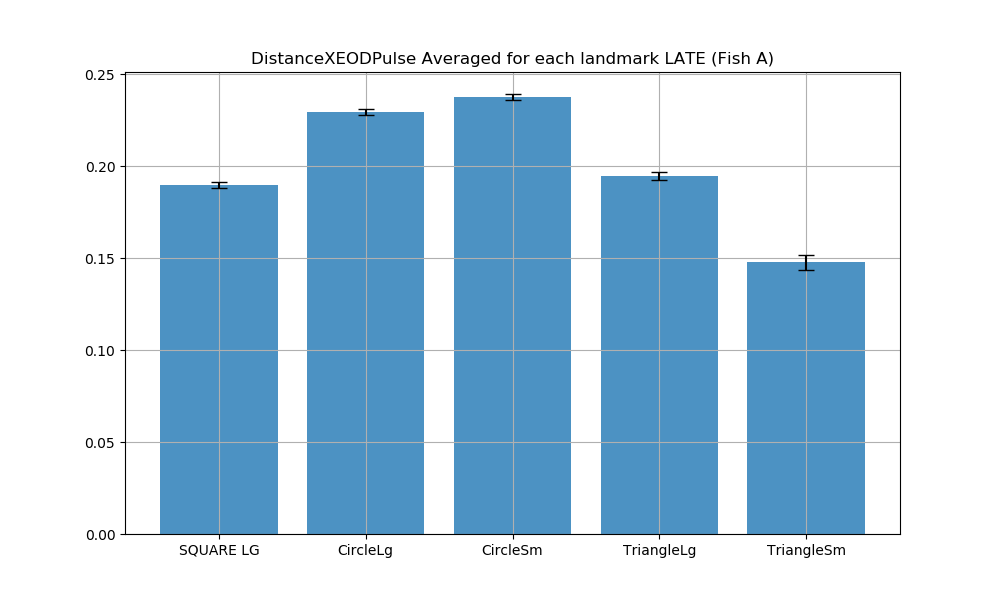

In [24]:
averages_fishA = [(mean1FishA),  (mean3FishA), ( mean4FishA),(mean5FishA), (mean6FishA)]#, (mean7FishA)/area_food]
averages_fishA = np.asarray(averages_fishA)
averages_fishA_norm = averages_fishA /averages_fishA.sum()

std_error_fishA = [(stdError1FishA) ,  (stdError3FishA) , (stdError4FishA ),(stdError5FishA) , (stdError6FishA)]#, (stdError7FishA)/area_food]
std_error_fishA = np.asarray(std_error_fishA)
std_error_fishA_norm = std_error_fishA / averages_fishA.sum()
x_bar_fishA = np.arange(5)

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("DistanceXEODPulse Averaged for each landmark LATE (Fish A)")
plt.bar(x_bar_fishA, averages_fishA_norm, yerr = std_error_fishA_norm,  alpha = 0.8, capsize = 6)
plt.grid()
plt.xticks(x_bar_fishA, ('SQUARE LG', 'CircleLg', 'CircleSm', 'TriangleLg', 'TriangleSm'))#,'Food'))
plt.savefig("Images/Shuffle/SamplingDensity/DistanceXEODFishA_LATE.png")

## Plot Probe Fish A 

<IPython.core.display.Javascript object>


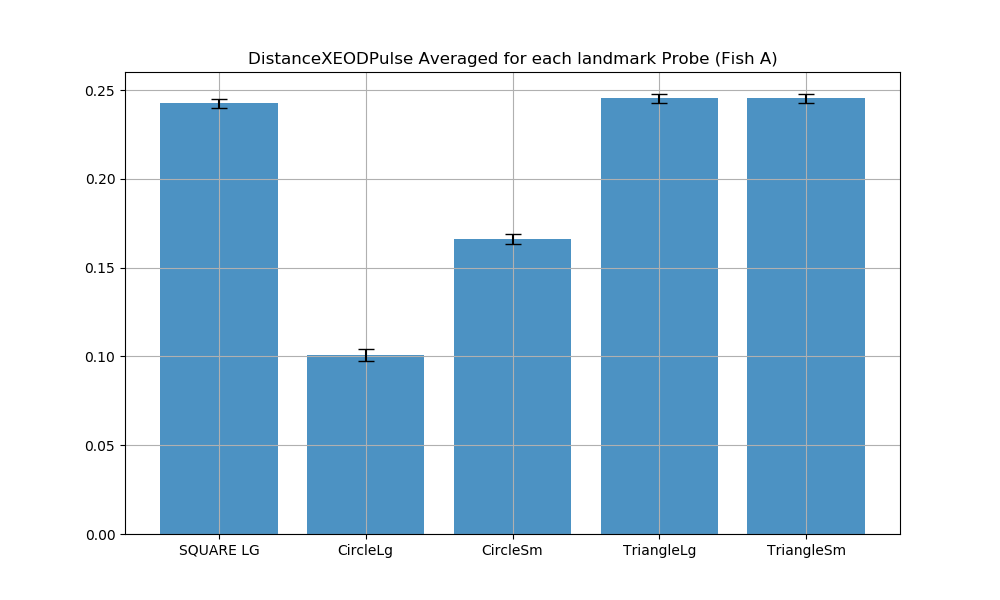

In [42]:
averages_fishA_probe = [(mean1fishA_probe),  (mean3fishA_probe), ( mean4fishA_probe),(mean5fishA_probe), (mean6fishA_probe)]#, (mean7FishA_probe)/area_food]
averages_fishA_probe = np.nan_to_num(np.asarray(averages_fishA_probe))

averages_fishA_probe_norm = averages_fishA_probe /averages_fishA_probe.sum()

std_error_fishA_probe = [(stdError1fishA_probe) ,  (stdError3fishA_probe) , (stdError4fishA_probe ),(stdError5fishA_probe) , (stdError6fishA_probe)]#, (stdError7FishA_probe)/area_food]
std_error_fishA_probe = np.nan_to_num(np.asarray(std_error_fishA_probe))
std_error_fishA_probe_norm = std_error_fishA_probe / averages_fishA_probe.sum()
x_bar_fishA_probe = np.arange(5)

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("DistanceXEODPulse Averaged for each landmark Probe (Fish A)")
plt.bar(x_bar_fishA_probe, averages_fishA_probe_norm, yerr = std_error_fishA_probe_norm,  alpha = 0.8, capsize = 6)
plt.grid()
plt.xticks(x_bar_fishA_probe, ('SQUARE LG', 'CircleLg', 'CircleSm', 'TriangleLg', 'TriangleSm'))#,'Food'))
plt.savefig("Images/Shuffle/SamplingDensity/DistanceXEODFishA_Probe.png")

### Area Normalization - presumably not correct 

<IPython.core.display.Javascript object>


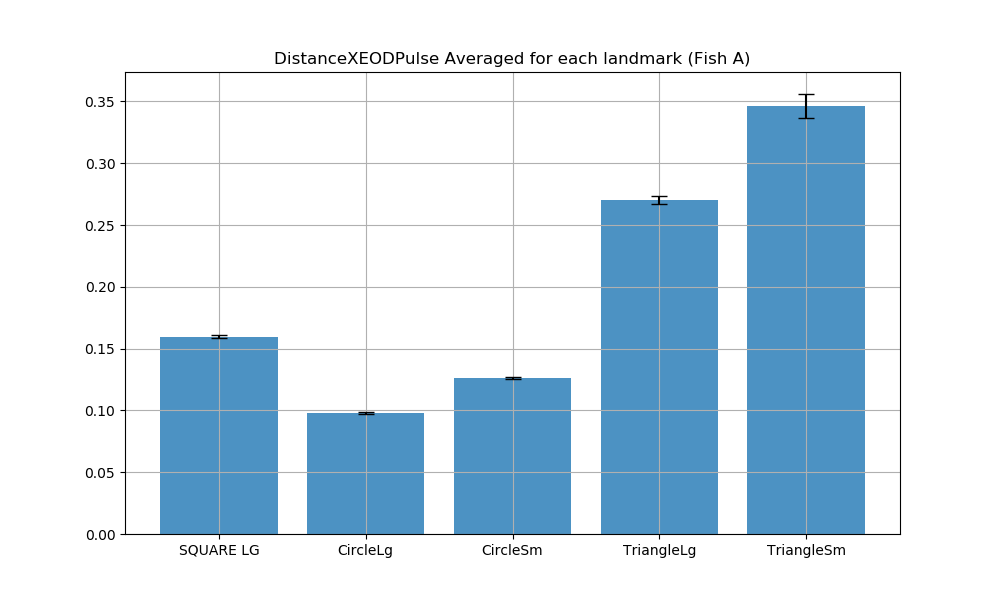

([<matplotlib.axis.XTick at 0x4ddb70f98>,
 <a list of 5 Text xticklabel objects>)

In [43]:
averages_fishA = [(mean1FishA)/area_large_square,  (mean3FishA)/area_large_circle, ( mean4FishA)/area_small_circle,(mean5FishA)/area_large_triangle, (mean6FishA)/area_small_triangle]#, (mean7FishA)/area_food]
averages_fishA = np.asarray(averages_fishA)
averages_fishA_norm = averages_fishA /averages_fishA.sum()

std_error_fishA = [(stdError1FishA)/area_large_square ,  (stdError3FishA)/area_large_circle , (stdError4FishA )/area_small_circle,(stdError5FishA)/area_large_triangle , (stdError6FishA)/area_small_triangle]#, (stdError7FishA)/area_food]
std_error_fishA = np.asarray(std_error_fishA)
std_error_fishA_norm = std_error_fishA / averages_fishA.sum()
x_bar_fishA = np.arange(5)

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("DistanceXEODPulse Averaged for each landmark (Fish A)")
plt.bar(x_bar_fishA, averages_fishA_norm, yerr = std_error_fishA_norm,  alpha = 0.8, capsize = 6)
plt.grid()
plt.xticks(x_bar_fishA, ('SQUARE LG', 'CircleLg', 'CircleSm', 'TriangleLg', 'TriangleSm'))#,'Food'))

### Fish B - Circle Lg (food associated) 

In [27]:
sampling_density_square_small_fishB = []
sampling_density_square_large_fishB = []
sampling_density_circle_small_fishB = []
sampling_density_circle_large_fishB = []
sampling_density_triangle_small_fishB = []
sampling_density_triangle_large_fishB = []
sampling_density_food_fishB = []

for i in tqdm(range(0,len(dataFishB))):
    sampling_density_square_small_fishB.append(active_square_small_fishB[i]['SamplingDensity'].values)
    sampling_density_square_large_fishB.append(active_square_large_fishB[i]['SamplingDensity'].values)
    sampling_density_circle_small_fishB.append(active_circle_small_fishB[i]['SamplingDensity'].values)
    sampling_density_circle_large_fishB.append(active_circle_large_fishB[i]['SamplingDensity'].values)
    sampling_density_triangle_small_fishB.append(active_triangle_small_fishB[i]['SamplingDensity'].values)
    sampling_density_triangle_large_fishB.append(active_triangle_large_fishB[i]['SamplingDensity'].values)
    sampling_density_food_fishB.append(active_food_fishB[i]['SamplingDensity'].values)
    

In [28]:
meanValues1FishB, meanValues2FishB, meanValues3FishB, meanValues4FishB, meanValues5FishB, meanValues6FishB, meanValues7FishB = [], [], [], [], [], [], []
early_FishB = 7
late_start_FishB = 60

for i in range(late_start_FishB, len(dataFishB)):
    if sampling_density_square_large_fishB[i].size is not 0: 
        meanValues1FishB = meanValues1FishB + list(sampling_density_square_large_fishB[i])
        
        
    if sampling_density_square_small_fishB[i].size is not 0:     
        meanValues2FishB += list(sampling_density_square_small_fishB[i])
        
    if sampling_density_circle_large_fishB[i].size is not 0: 
        meanValues3FishB += list(sampling_density_circle_large_fishB[i])
        
    if sampling_density_circle_small_fishB[i].size is not 0: 
        meanValues4FishB += list(sampling_density_circle_small_fishB[i])
        
    if sampling_density_triangle_large_fishB[i].size is not 0: 
        meanValues5FishB += list(sampling_density_triangle_large_fishB[i])
        
    if sampling_density_triangle_small_fishB[i].size is not 0: 
        meanValues6FishB += list(sampling_density_triangle_small_fishB[i])
        
    if sampling_density_food_fishB[i].size is not 0: 
        meanValues7FishB +=list(sampling_density_food_fishB[i])
        
meanValues1FishB = np.asarray(meanValues1FishB)
meanValues2FishB = np.asarray(meanValues2FishB)
meanValues3FishB = np.asarray(meanValues3FishB)
meanValues4FishB = np.asarray(meanValues4FishB)
meanValues5FishB = np.asarray(meanValues5FishB)
meanValues6FishB = np.asarray(meanValues6FishB)
meanValues7FishB = np.asarray(meanValues7FishB)

meanAllValues = np.concatenate((meanValues1FishB, meanValues3FishB, meanValues2FishB, meanValues5FishB, meanValues6FishB, meanValues7FishB))

meanValues1FishB = (meanValues1FishB - meanAllValues.min())/(meanAllValues.max() - meanAllValues.min())
meanValues3FishB = (meanValues3FishB - meanAllValues.min())/(meanAllValues.max() - meanAllValues.min())
meanValues2FishB = (meanValues2FishB - meanAllValues.min())/(meanAllValues.max() - meanAllValues.min())
meanValues5FishB = (meanValues5FishB - meanAllValues.min())/(meanAllValues.max() - meanAllValues.min())
meanValues6FishB = (meanValues6FishB - meanAllValues.min())/(meanAllValues.max() - meanAllValues.min())
meanValues7FishB = (meanValues7FishB - meanAllValues.min())/(meanAllValues.max() - meanAllValues.min())

mean1FishB = meanValues1FishB.mean()
mean2FishB = meanValues2FishB.mean()
mean3FishB = meanValues3FishB.mean()
mean4FishB = meanValues4FishB.mean()
mean5FishB = meanValues5FishB.mean()
mean6FishB = meanValues6FishB.mean()
mean7FishB = meanValues7FishB.mean()

stdError1FishB = meanValues1FishB.std()/np.sqrt(len(meanValues1FishB))
stdError2FishB = meanValues2FishB.std()/np.sqrt(len(meanValues2FishB))
stdError3FishB = meanValues3FishB.std()/np.sqrt(len(meanValues3FishB))
stdError4FishB = meanValues4FishB.std()/np.sqrt(len(meanValues4FishB))
stdError5FishB = meanValues5FishB.std()/np.sqrt(len(meanValues5FishB))
stdError6FishB = meanValues6FishB.std()/np.sqrt(len(meanValues6FishB))
stdError7FishB = meanValues7FishB.std()/np.sqrt(len(meanValues7FishB))

### Probe Fish B 

In [29]:
sampling_density_square_small_fishB_probe = []
sampling_density_square_large_fishB_probe = []
sampling_density_circle_small_fishB_probe = []
sampling_density_circle_large_fishB_probe = []
sampling_density_triangle_small_fishB_probe = []
sampling_density_triangle_large_fishB_probe = []


for i in tqdm(range(0,len(dataProbeFishB))):
    sampling_density_square_small_fishB_probe.append(active_square_small_fishB_probe[i]['SamplingDensity'].astype(np.float).values)
    sampling_density_square_large_fishB_probe.append(active_square_large_fishB_probe[i]['SamplingDensity'].astype(np.float).values)
    sampling_density_circle_small_fishB_probe.append(active_circle_small_fishB_probe[i]['SamplingDensity'].astype(np.float).values)
    sampling_density_circle_large_fishB_probe.append(active_circle_large_fishB_probe[i]['SamplingDensity'].astype(np.float).values)
    sampling_density_triangle_small_fishB_probe.append(active_triangle_small_fishB_probe[i]['SamplingDensity'].astype(np.float).values)
    sampling_density_triangle_large_fishB_probe.append(active_triangle_large_fishB_probe[i]['SamplingDensity'].astype(np.float).values)
    


In [30]:
meanValues1fishB_probe, meanValues2fishB_probe, meanValues3fishB_probe, meanValues4fishB_probe, meanValues5fishB_probe, meanValues6fishB_probe, meanValues7fishB_probe = [], [], [], [], [], [], []


for i in range(0, len(dataProbeFishB) ):
    if sampling_density_square_large_fishB_probe[i].size is not 0: 
        meanValues1fishB_probe = meanValues1fishB_probe + list(sampling_density_square_large_fishB_probe[i])
        
    if sampling_density_square_small_fishB_probe[i].size is not 0:     
        meanValues2fishB_probe += list(sampling_density_square_small_fishB_probe[i])
        
    if sampling_density_circle_large_fishB_probe[i].size is not 0: 
        meanValues3fishB_probe += list(sampling_density_circle_large_fishB_probe[i])
        
    if sampling_density_circle_small_fishB_probe[i].size is not 0: 
        meanValues4fishB_probe += list(sampling_density_circle_small_fishB_probe[i])
        
    if sampling_density_triangle_large_fishB_probe[i].size is not 0: 
        meanValues5fishB_probe += list(sampling_density_triangle_large_fishB_probe[i])
        
    if sampling_density_triangle_small_fishB_probe[i].size is not 0: 
        meanValues6fishB_probe += list(sampling_density_triangle_small_fishB_probe[i])
        
        
meanValues1fishB_probe = np.asarray(meanValues1fishB_probe)
meanValues2fishB_probe = np.asarray(meanValues2fishB_probe)
meanValues3fishB_probe = np.asarray(meanValues3fishB_probe)
meanValues4fishB_probe = np.asarray(meanValues4fishB_probe)
meanValues5fishB_probe = np.asarray(meanValues5fishB_probe)
meanValues6fishB_probe = np.asarray(meanValues6fishB_probe)
meanValues7fishB_probe = np.asarray(meanValues7fishB_probe)

meanAllValues = np.concatenate((meanValues1fishB_probe, meanValues3fishB_probe, meanValues4fishB_probe, meanValues5fishB_probe, meanValues6fishB_probe, meanValues7fishB_probe))


mean1fishB_probe = meanValues1fishB_probe.mean()
mean2fishB_probe = meanValues2fishB_probe.mean()
mean3fishB_probe = meanValues3fishB_probe.mean()
mean4fishB_probe = meanValues4fishB_probe.mean()
mean5fishB_probe = meanValues5fishB_probe.mean()
mean6fishB_probe = meanValues6fishB_probe.mean()
mean7fishB_probe = meanValues7fishB_probe.mean()

stdError1fishB_probe = meanValues1fishB_probe.std()/np.sqrt(len(meanValues1fishB_probe))
stdError2fishB_probe = meanValues2fishB_probe.std()/np.sqrt(len(meanValues2fishB_probe))
stdError3fishB_probe = meanValues3fishB_probe.std()/np.sqrt(len(meanValues3fishB_probe))
stdError4fishB_probe = meanValues4fishB_probe.std()/np.sqrt(len(meanValues4fishB_probe))
stdError5fishB_probe = meanValues5fishB_probe.std()/np.sqrt(len(meanValues5fishB_probe))
stdError6fishB_probe = meanValues6fishB_probe.std()/np.sqrt(len(meanValues6fishB_probe))
stdError7fishB_probe = meanValues7fishB_probe.std()/np.sqrt(len(meanValues7fishB_probe))

C:\Users\jamesjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
C:\Users\jamesjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice.


### No normalization 

<IPython.core.display.Javascript object>


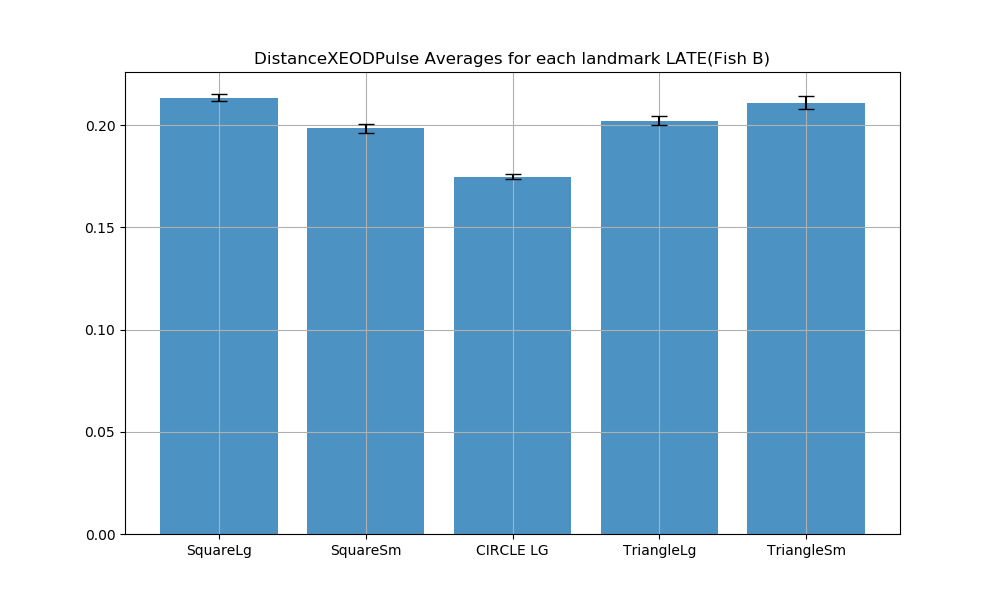

In [31]:
averages_fishB = [(mean1FishB), (mean2FishB), (mean3FishB), (mean5FishB), ( mean6FishB)]#, ( mean7FishB)/area_food]
averages_fishB = np.asarray(averages_fishB)
averages_fishB_norm = averages_fishB /averages_fishB.sum()

std_error_fishB = [(stdError1FishB ), (stdError2FishB ), (stdError3FishB) , (stdError5FishB) , (stdError6FishB)]#, (stdError7FishB)/area_food]
std_error_fishB = np.asarray(std_error_fishB)
std_error_fishB_norm = std_error_fishB / averages_fishB.sum()
x_bar_fishB = np.arange(5)

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("DistanceXEODPulse Averages for each landmark LATE(Fish B)")
plt.bar(x_bar_fishB, averages_fishB_norm, yerr = std_error_fishB_norm,  alpha = 0.8, capsize = 6)
plt.grid()
plt.xticks(x_bar_fishB, ('SquareLg', 'SquareSm','CIRCLE LG', 'TriangleLg', 'TriangleSm'))#,'Food'))
plt.savefig("Images/Shuffle/SamplingDensity/DistanceXEODFishB_LATE.png")

### Area Normalization

<IPython.core.display.Javascript object>


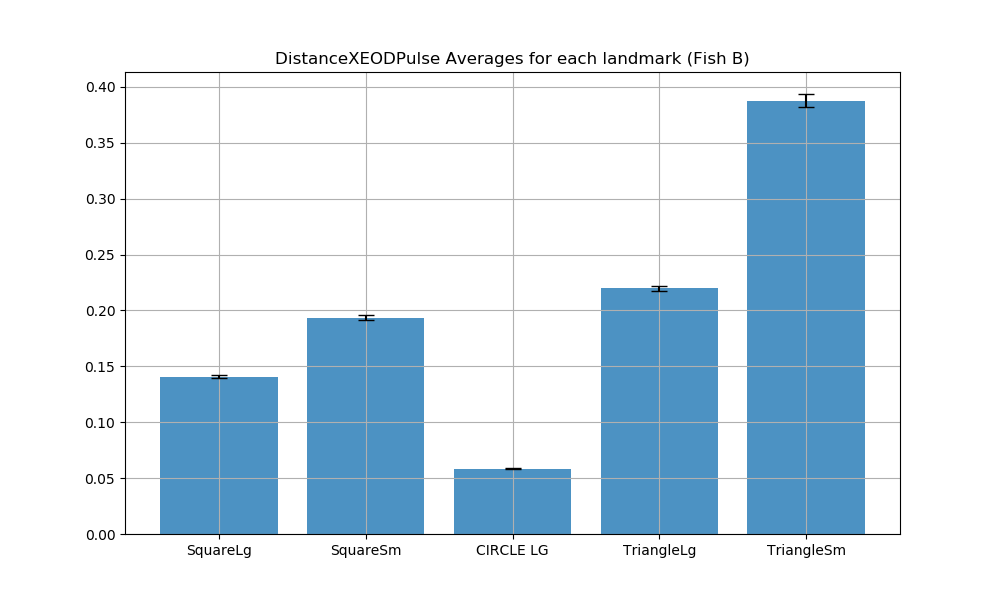

([<matplotlib.axis.XTick at 0x4d70bd0f0>,
 <a list of 5 Text xticklabel objects>)

In [32]:
averages_fishB = [(mean1FishB)/area_large_square, (mean2FishB)/area_small_square, (mean3FishB)/area_large_circle, (mean5FishB)/area_large_triangle, ( mean6FishB)/area_small_triangle]#, ( mean7FishB)/area_food]
averages_fishB = np.asarray(averages_fishB)
averages_fishB_norm = averages_fishB /averages_fishB.sum()

std_error_fishB = [(stdError1FishB )/area_large_square , (stdError2FishB )/area_small_square, (stdError3FishB)/area_large_circle , (stdError5FishB)/area_large_triangle , (stdError6FishB)/area_small_triangle]#, (stdError7FishB)/area_food]
std_error_fishB = np.asarray(std_error_fishB)
std_error_fishB_norm = std_error_fishB / averages_fishB.sum()
x_bar_fishB = np.arange(5)

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("DistanceXEODPulse Averages for each landmark (Fish B)")
plt.bar(x_bar_fishB, averages_fishB_norm, yerr = std_error_fishB_norm,  alpha = 0.8, capsize = 6)
plt.grid()
plt.xticks(x_bar_fishB, ('SquareLg', 'SquareSm','CIRCLE LG', 'TriangleLg', 'TriangleSm'))#,'Food'))

### Probe Fish B 

<IPython.core.display.Javascript object>


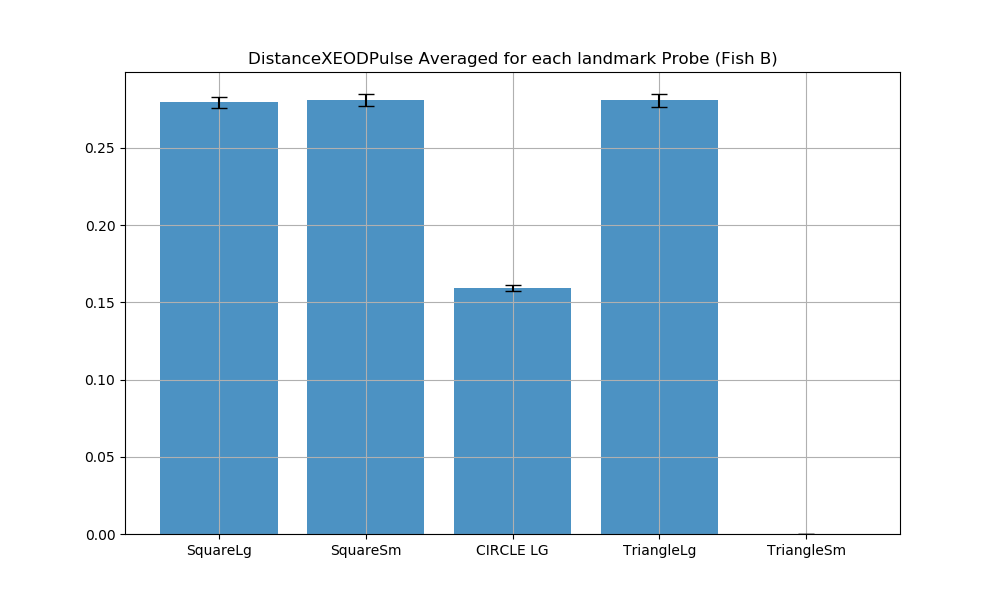

In [33]:
averages_fishB_probe = [(mean1fishB_probe),  (mean2fishB_probe), ( mean3fishB_probe),(mean5fishB_probe), (mean6fishB_probe)]#, (mean7FishB_probe)/area_food]
averages_fishB_probe = np.nan_to_num(np.asarray(averages_fishB_probe))

averages_fishB_probe_norm = averages_fishB_probe /averages_fishB_probe.sum()

std_error_fishB_probe = [(stdError1fishB_probe) ,  (stdError2fishB_probe) , (stdError3fishB_probe ),(stdError5fishB_probe) , (stdError6fishB_probe)]#, (stdError7FishB_probe)/area_food]
std_error_fishB_probe = np.nan_to_num(np.asarray(std_error_fishB_probe))
std_error_fishB_probe_norm = std_error_fishB_probe / averages_fishB_probe.sum()
x_bar_fishB_probe = np.arange(5)

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("DistanceXEODPulse Averaged for each landmark Probe (Fish B)")
plt.bar(x_bar_fishB_probe, averages_fishB_probe_norm, yerr = std_error_fishB_probe_norm,  alpha = 0.8, capsize = 6)
plt.grid()
plt.xticks(x_bar_fishB_probe, ('SquareLg', 'SquareSm','CIRCLE LG', 'TriangleLg', 'TriangleSm'))#,'Food'))
plt.savefig("Images/Shuffle/SamplingDensity/DistanceXEODFishB_Probe.png")

# Visit Density 
Number of times animals visit each grid location

## Fish A 

In [34]:
visit_density_circle_small_fishA = []
visit_density_circle_large_fishA = []
visit_density_square_large_fishA = []
visit_density_triangle_small_fishA = []
visit_density_triangle_large_fishA = []
visit_density_food_fishA = []

for i in range(late_start_fishA ,len(dataFishA)):#len(dataFishA)):
    visit_density_circle_small_fishA.append(len(active_circle_small_fishA[i]))
    visit_density_circle_large_fishA.append(len(active_circle_large_fishA[i]))
    visit_density_square_large_fishA.append(len(active_square_large_fishA[i]))
    visit_density_triangle_small_fishA.append(len(active_triangle_small_fishA[i]))
    visit_density_triangle_large_fishA.append(len(active_triangle_large_fishA[i]))
    visit_density_food_fishA.append(len(active_food_fishA[i]))
    
        
visit_density_circle_small_fishA = np.asarray(visit_density_circle_small_fishA)
visit_density_circle_large_fishA = np.asarray(visit_density_circle_large_fishA)
visit_density_square_large_fishA = np.asarray(visit_density_square_large_fishA)
visit_density_triangle_small_fishA = np.asarray(visit_density_triangle_small_fishA)
visit_density_triangle_large_fishA = np.asarray(visit_density_triangle_large_fishA)
visit_density_food_fishA = np.asarray(visit_density_food_fishA)

meanVD_circle_small_fishA = visit_density_circle_small_fishA.mean()
meanVD_circle_large_fishA = visit_density_circle_large_fishA.mean()
meanVD_square_large_fishA = visit_density_square_large_fishA.mean()
meanVD_triangle_small_fishA = visit_density_triangle_small_fishA.mean()
meanVD_triangle_large_fishA = visit_density_triangle_large_fishA.mean()
meanVD_food_fishA = visit_density_food_fishA.mean()

stdErrorVD_circle_small_fishA = visit_density_circle_small_fishA.std()/np.sqrt(len(visit_density_circle_small_fishA))
stdErrorVD_circle_large_fishA = visit_density_circle_large_fishA.std()/np.sqrt(len(visit_density_circle_large_fishA))
stdErrorVD_square_large_fishA = visit_density_square_large_fishA.std()/np.sqrt(len(visit_density_square_large_fishA))
stdErrorVD_triangle_small_fishA = visit_density_triangle_small_fishA.std()/np.sqrt(len(visit_density_triangle_small_fishA))
stdErrorVD_triangle_large_fishA = visit_density_triangle_large_fishA.std()/np.sqrt(len(visit_density_triangle_large_fishA))
stdErrorVD_food_fishA = visit_density_food_fishA.std()/np.sqrt(len(visit_density_food_fishA))

### Probe Fish A 

In [35]:
visit_density_circle_small_fishA_probe = []
visit_density_circle_large_fishA_probe = []
visit_density_square_large_fishA_probe = []
visit_density_triangle_small_fishA_probe = []
visit_density_triangle_large_fishA_probe = []
visit_density_food_fishA_probe = []

for i in range(0 ,len(dataProbeFishA)):#len(dataFishA)):
    visit_density_circle_small_fishA_probe.append(len(active_circle_small_fishA_probe[i]))
    visit_density_circle_large_fishA_probe.append(len(active_circle_large_fishA_probe[i]))
    visit_density_square_large_fishA_probe.append(len(active_square_large_fishA_probe[i]))
    visit_density_triangle_small_fishA_probe.append(len(active_triangle_small_fishA_probe[i]))
    visit_density_triangle_large_fishA_probe.append(len(active_triangle_large_fishA_probe[i]))
    visit_density_food_fishA_probe.append(len(active_food_fishA_probe[i]))
    
        
visit_density_circle_small_fishA_probe = np.asarray(visit_density_circle_small_fishA_probe)
visit_density_circle_large_fishA_probe = np.asarray(visit_density_circle_large_fishA_probe)
visit_density_square_large_fishA_probe = np.asarray(visit_density_square_large_fishA_probe)
visit_density_triangle_small_fishA_probe = np.asarray(visit_density_triangle_small_fishA_probe)
visit_density_triangle_large_fishA_probe = np.asarray(visit_density_triangle_large_fishA_probe)
visit_density_food_fishA_probe = np.asarray(visit_density_food_fishA_probe)

meanVD_circle_small_fishA_probe = visit_density_circle_small_fishA_probe.mean()
meanVD_circle_large_fishA_probe = visit_density_circle_large_fishA_probe.mean()
meanVD_square_large_fishA_probe = visit_density_square_large_fishA_probe.mean()
meanVD_triangle_small_fishA_probe = visit_density_triangle_small_fishA_probe.mean()
meanVD_triangle_large_fishA_probe = visit_density_triangle_large_fishA_probe.mean()
meanVD_food_fishA_probe = visit_density_food_fishA_probe.mean()

stdErrorVD_circle_small_fishA_probe = visit_density_circle_small_fishA_probe.std()/np.sqrt(len(visit_density_circle_small_fishA_probe))
stdErrorVD_circle_large_fishA_probe = visit_density_circle_large_fishA_probe.std()/np.sqrt(len(visit_density_circle_large_fishA_probe))
stdErrorVD_square_large_fishA_probe = visit_density_square_large_fishA_probe.std()/np.sqrt(len(visit_density_square_large_fishA_probe))
stdErrorVD_triangle_small_fishA_probe = visit_density_triangle_small_fishA_probe.std()/np.sqrt(len(visit_density_triangle_small_fishA_probe))
stdErrorVD_triangle_large_fishA_probe = visit_density_triangle_large_fishA_probe.std()/np.sqrt(len(visit_density_triangle_large_fishA_probe))
stdErrorVD_food_fishA_probe = visit_density_food_fishA_probe.std()/np.sqrt(len(visit_density_food_fishA_probe))

### No Normalization 

<IPython.core.display.Javascript object>


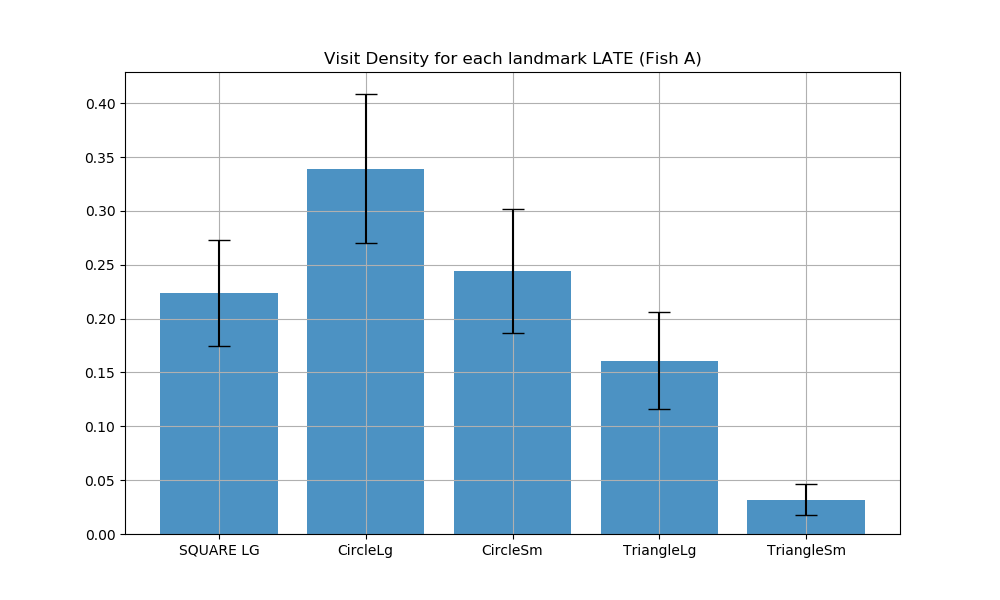

In [36]:
averagesVD_fishA = [ meanVD_square_large_fishA, meanVD_circle_large_fishA, meanVD_circle_small_fishA, meanVD_triangle_large_fishA, meanVD_triangle_small_fishA]#,  meanVD_food_fishA/area_food]
averagesVD_fishA = np.asarray(averagesVD_fishA)
averagesVD_fishA_norm = averagesVD_fishA/averagesVD_fishA.sum()
x_bar_fishA = np.arange(5)
std_error_fishA = [stdErrorVD_square_large_fishA, stdErrorVD_circle_large_fishA, stdErrorVD_circle_small_fishA, stdErrorVD_triangle_large_fishA, stdErrorVD_triangle_small_fishA]#, stdErrorVD_food_fishA/area_food ]
std_error_fishA = np.asarray(std_error_fishA)
std_error_fishA_norm = std_error_fishA/averagesVD_fishA.sum()

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("Visit Density for each landmark LATE (Fish A)")
plt.bar(x_bar_fishA, averagesVD_fishA_norm, yerr = std_error_fishA_norm  , alpha = 0.8, capsize = 8)
plt.grid()
plt.xticks(x_bar_fishA, ('SQUARE LG', 'CircleLg', 'CircleSm', 'TriangleLg', 'TriangleSm'))#,'Food'))
plt.savefig("Images/Shuffle/SamplingDensity/VisitDensityFishA_LATE.png")

### Area Normalization 

<IPython.core.display.Javascript object>


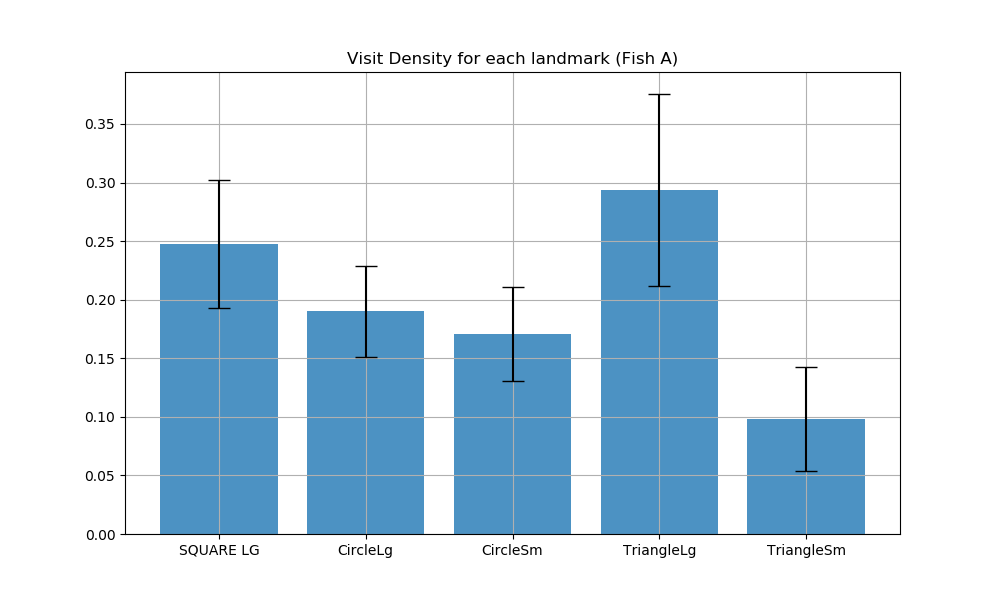

([<matplotlib.axis.XTick at 0x4dab31f60>,
 <a list of 5 Text xticklabel objects>)

In [37]:
averagesVD_fishA = [ meanVD_square_large_fishA/area_large_square, meanVD_circle_large_fishA/area_large_circle, meanVD_circle_small_fishA/area_small_circle, meanVD_triangle_large_fishA/area_large_triangle, meanVD_triangle_small_fishA/area_small_triangle]#,  meanVD_food_fishA/area_food]
averagesVD_fishA = np.asarray(averagesVD_fishA)
averagesVD_fishA_norm = averagesVD_fishA/averagesVD_fishA.sum()
x_bar_fishA = np.arange(5)
std_error_fishA = [stdErrorVD_square_large_fishA/area_large_square, stdErrorVD_circle_large_fishA/area_large_circle, stdErrorVD_circle_small_fishA/area_small_circle, stdErrorVD_triangle_large_fishA/area_large_triangle, stdErrorVD_triangle_small_fishA/area_small_triangle]#, stdErrorVD_food_fishA/area_food ]
std_error_fishA = np.asarray(std_error_fishA)
std_error_fishA_norm = std_error_fishA/averagesVD_fishA.sum()

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("Visit Density for each landmark (Fish A)")
plt.bar(x_bar_fishA, averagesVD_fishA_norm, yerr = std_error_fishA_norm  , alpha = 0.8, capsize = 8)
plt.grid()
plt.xticks(x_bar_fishA, ('SQUARE LG', 'CircleLg', 'CircleSm', 'TriangleLg', 'TriangleSm'))#,'Food'))


### Probe Fish A

<IPython.core.display.Javascript object>


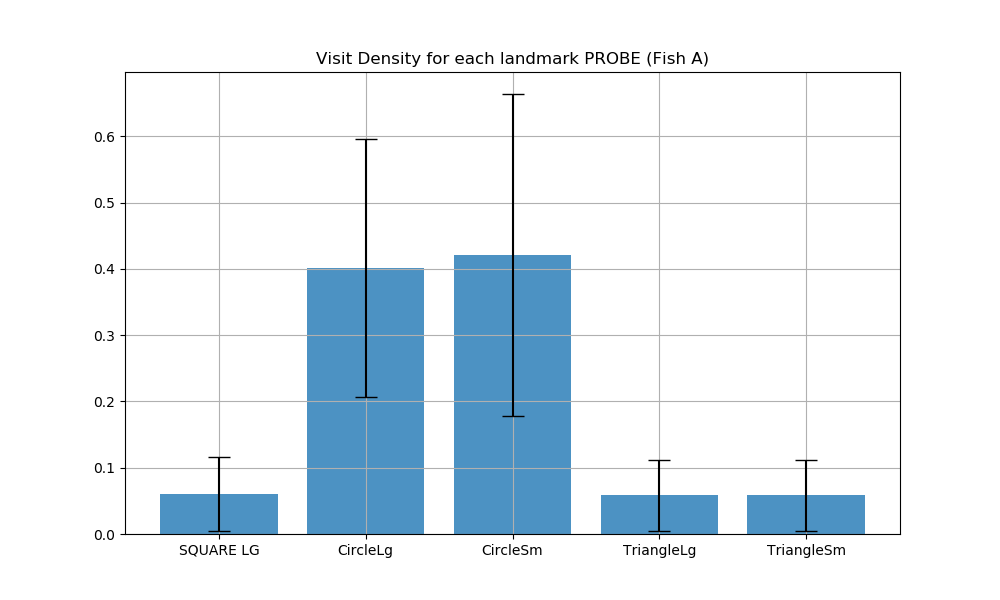

In [38]:
averagesVD_fishA_probe = [ meanVD_square_large_fishA_probe, meanVD_circle_large_fishA_probe, meanVD_circle_small_fishA_probe, meanVD_triangle_large_fishA_probe, meanVD_triangle_small_fishA_probe]#,  meanVD_food_fishA_probe/area_food]
averagesVD_fishA_probe = np.asarray(averagesVD_fishA_probe)
averagesVD_fishA_probe_norm = averagesVD_fishA_probe/averagesVD_fishA_probe.sum()
x_bar_fishA_probe = np.arange(5)
std_error_fishA_probe = [stdErrorVD_square_large_fishA_probe, stdErrorVD_circle_large_fishA_probe, stdErrorVD_circle_small_fishA_probe, stdErrorVD_triangle_large_fishA_probe, stdErrorVD_triangle_small_fishA_probe]#, stdErrorVD_food_fishA_probe/area_food ]
std_error_fishA_probe = np.asarray(std_error_fishA_probe)
std_error_fishA_probe_norm = std_error_fishA_probe/averagesVD_fishA_probe.sum()

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("Visit Density for each landmark PROBE (Fish A)")
plt.bar(x_bar_fishA_probe, averagesVD_fishA_probe_norm, yerr = std_error_fishA_probe_norm  , alpha = 0.8, capsize = 8)
plt.grid()
plt.xticks(x_bar_fishA_probe, ('SQUARE LG', 'CircleLg', 'CircleSm', 'TriangleLg', 'TriangleSm'))#,'Food'))
plt.savefig("Images/Shuffle/SamplingDensity/VisitDensityFishA_Probe.png")

## Fish B

In [44]:
visit_density_square_small_fishB = []
visit_density_circle_large_fishB = []
visit_density_square_large_fishB = []
visit_density_triangle_small_fishB = []
visit_density_triangle_large_fishB = []
visit_density_food_fishB = []

for i in range(late_start_FishB,len(dataFishB)): #len(dataFishB)
    visit_density_square_small_fishB.append(len(active_square_small_fishB[i]))
    visit_density_circle_large_fishB.append(len(active_circle_large_fishB[i]))
    visit_density_square_large_fishB.append(len(active_square_large_fishB[i]))
    visit_density_triangle_small_fishB.append(len(active_triangle_small_fishB[i]))
    visit_density_triangle_large_fishB.append(len(active_triangle_large_fishB[i]))
    visit_density_food_fishB.append(len(active_food_fishB[i]))
    
        
visit_density_square_small_fishB = np.asarray(visit_density_square_small_fishB)
visit_density_circle_large_fishB = np.asarray(visit_density_circle_large_fishB)
visit_density_square_large_fishB = np.asarray(visit_density_square_large_fishB)
visit_density_triangle_small_fishB = np.asarray(visit_density_triangle_small_fishB)
visit_density_triangle_large_fishB = np.asarray(visit_density_triangle_large_fishB)
visit_density_food_fishB = np.asarray(visit_density_food_fishB)

meanVD_square_small_fishB = visit_density_square_small_fishB.mean()
meanVD_circle_large_fishB = visit_density_circle_large_fishB.mean()
meanVD_square_large_fishB = visit_density_square_large_fishB.mean()
meanVD_triangle_small_fishB = visit_density_triangle_small_fishB.mean()
meanVD_triangle_large_fishB = visit_density_triangle_large_fishB.mean()
meanVD_food_fishB = visit_density_food_fishB.mean()

stdErrorVD_square_small_fishB = visit_density_square_small_fishB.std()/np.sqrt(len(visit_density_square_small_fishB))
stdErrorVD_circle_large_fishB = visit_density_circle_large_fishB.std()/np.sqrt(len(visit_density_circle_large_fishB))
stdErrorVD_square_large_fishB = visit_density_square_large_fishB.std()/np.sqrt(len(visit_density_square_large_fishB))
stdErrorVD_triangle_small_fishB = visit_density_triangle_small_fishB.std()/np.sqrt(len(visit_density_triangle_small_fishB))
stdErrorVD_triangle_large_fishB = visit_density_triangle_large_fishB.std()/np.sqrt(len(visit_density_triangle_large_fishB))
stdErrorVD_food_fishB = visit_density_food_fishB.std()/np.sqrt(len(visit_density_food_fishB))

### Probe- Fish B 


In [45]:
visit_density_square_small_fishB_probe = []
visit_density_circle_large_fishB_probe = []
visit_density_square_large_fishB_probe = []
visit_density_triangle_small_fishB_probe = []
visit_density_triangle_large_fishB_probe = []
visit_density_food_fishB_probe = []

for i in range(0 ,len(dataProbeFishB)):#len(dataFishB)):
    visit_density_square_small_fishB_probe.append(len(active_square_small_fishB_probe[i]))
    visit_density_circle_large_fishB_probe.append(len(active_circle_large_fishB_probe[i]))
    visit_density_square_large_fishB_probe.append(len(active_square_large_fishB_probe[i]))
    visit_density_triangle_small_fishB_probe.append(len(active_triangle_small_fishB_probe[i]))
    visit_density_triangle_large_fishB_probe.append(len(active_triangle_large_fishB_probe[i]))
    visit_density_food_fishB_probe.append(len(active_food_fishB_probe[i]))
    
        
visit_density_square_small_fishB_probe = np.asarray(visit_density_square_small_fishB_probe)
visit_density_circle_large_fishB_probe = np.asarray(visit_density_circle_large_fishB_probe)
visit_density_square_large_fishB_probe = np.asarray(visit_density_square_large_fishB_probe)
visit_density_triangle_small_fishB_probe = np.asarray(visit_density_triangle_small_fishB_probe)
visit_density_triangle_large_fishB_probe = np.asarray(visit_density_triangle_large_fishB_probe)
visit_density_food_fishB_probe = np.asarray(visit_density_food_fishB_probe)

meanVD_square_small_fishB_probe = visit_density_square_small_fishB_probe.mean()
meanVD_circle_large_fishB_probe = visit_density_circle_large_fishB_probe.mean()
meanVD_square_large_fishB_probe = visit_density_square_large_fishB_probe.mean()
meanVD_triangle_small_fishB_probe = visit_density_triangle_small_fishB_probe.mean()
meanVD_triangle_large_fishB_probe = visit_density_triangle_large_fishB_probe.mean()
meanVD_food_fishB_probe = visit_density_food_fishB_probe.mean()

stdErrorVD_square_small_fishB_probe = visit_density_square_small_fishB_probe.std()/np.sqrt(len(visit_density_square_small_fishB_probe))
stdErrorVD_circle_large_fishB_probe = visit_density_circle_large_fishB_probe.std()/np.sqrt(len(visit_density_circle_large_fishB_probe))
stdErrorVD_square_large_fishB_probe = visit_density_square_large_fishB_probe.std()/np.sqrt(len(visit_density_square_large_fishB_probe))
stdErrorVD_triangle_small_fishB_probe = visit_density_triangle_small_fishB_probe.std()/np.sqrt(len(visit_density_triangle_small_fishB_probe))
stdErrorVD_triangle_large_fishB_probe = visit_density_triangle_large_fishB_probe.std()/np.sqrt(len(visit_density_triangle_large_fishB_probe))
stdErrorVD_food_fishB_probe = visit_density_food_fishB_probe.std()/np.sqrt(len(visit_density_food_fishB_probe))

### No Normalization 

<IPython.core.display.Javascript object>


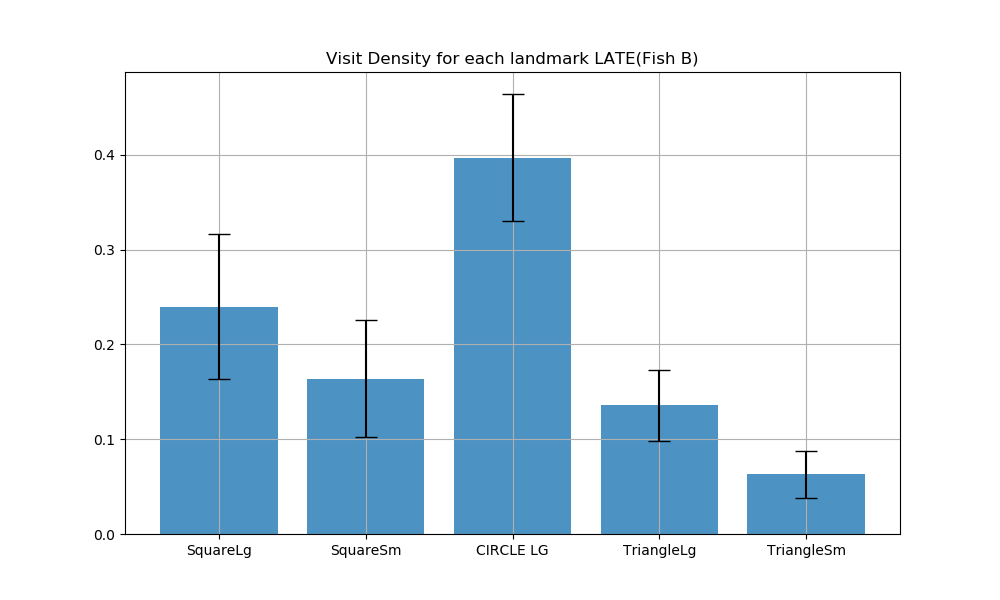

In [46]:
averagesVD_fishB = [ meanVD_square_large_fishB, meanVD_square_small_fishB, meanVD_circle_large_fishB,  meanVD_triangle_large_fishB, meanVD_triangle_small_fishB]#,  meanVD_food_fishB/area_food]
averagesVD_fishB = np.asarray(averagesVD_fishB)
averagesVD_fishB_norm = averagesVD_fishB/averagesVD_fishB.sum()
x_bar_fishB = np.arange(5)
std_error_fishB = [stdErrorVD_square_large_fishB, stdErrorVD_square_small_fishB, stdErrorVD_circle_large_fishB,  stdErrorVD_triangle_large_fishB, stdErrorVD_triangle_small_fishB]#, stdErrorVD_food_fishB/area_food ]
std_error_fishB = np.asarray(std_error_fishB)
std_error_fishB_norm = std_error_fishB/averagesVD_fishB.sum()

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("Visit Density for each landmark LATE(Fish B)")
plt.bar(x_bar_fishB, averagesVD_fishB_norm, yerr = std_error_fishB_norm  , alpha = 0.8, capsize = 8)
plt.grid()
plt.xticks(x_bar_fishB, ('SquareLg', 'SquareSm','CIRCLE LG', 'TriangleLg', 'TriangleSm'))#,'Food'))
plt.savefig("Images/Shuffle/SamplingDensity/VisitDensityFishB_LATE.png")

### Area Normalization 

<IPython.core.display.Javascript object>


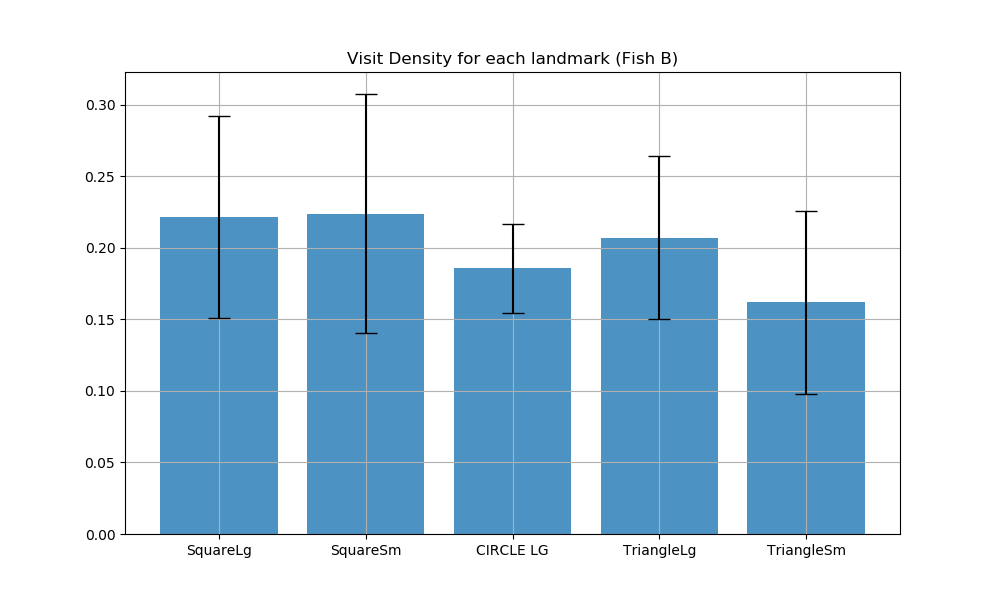

([<matplotlib.axis.XTick at 0x4de0ec7b8>,
 <a list of 5 Text xticklabel objects>)

In [47]:
averagesVD_fishB = [ meanVD_square_large_fishB/area_large_square, meanVD_square_small_fishB/area_small_square, meanVD_circle_large_fishB/area_large_circle,  meanVD_triangle_large_fishB/area_large_triangle, meanVD_triangle_small_fishB/area_small_triangle]#,  meanVD_food_fishB/area_food]
averagesVD_fishB = np.asarray(averagesVD_fishB)
averagesVD_fishB_norm = averagesVD_fishB/averagesVD_fishB.sum()
x_bar_fishB = np.arange(5)
std_error_fishB = [stdErrorVD_square_large_fishB/area_large_square, stdErrorVD_square_small_fishB/area_small_square, stdErrorVD_circle_large_fishB/area_large_circle,  stdErrorVD_triangle_large_fishB/area_large_triangle, stdErrorVD_triangle_small_fishB/area_small_triangle]#, stdErrorVD_food_fishB/area_food ]
std_error_fishB = np.asarray(std_error_fishB)
std_error_fishB_norm = std_error_fishB/averagesVD_fishB.sum()

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("Visit Density for each landmark (Fish B)")
plt.bar(x_bar_fishB, averagesVD_fishB_norm, yerr = std_error_fishB_norm  , alpha = 0.8, capsize = 8)
plt.grid()
plt.xticks(x_bar_fishB, ('SquareLg', 'SquareSm','CIRCLE LG', 'TriangleLg', 'TriangleSm'))#,'Food'))


### Probe B Data

<IPython.core.display.Javascript object>


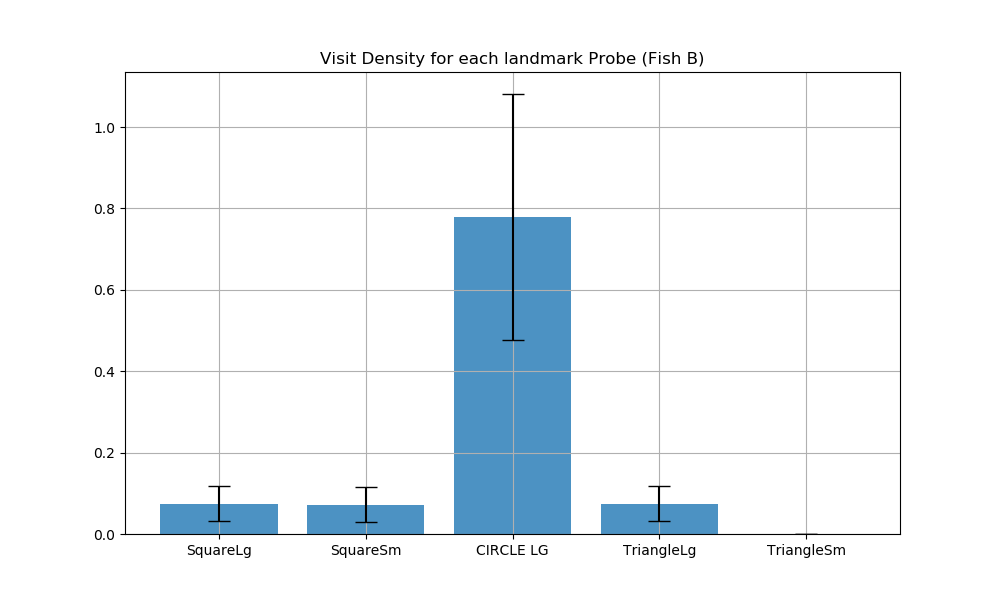

In [48]:
averagesVD_fishB_probe = [ meanVD_square_large_fishB_probe, meanVD_square_small_fishB_probe, meanVD_circle_large_fishB_probe,  meanVD_triangle_large_fishB_probe, meanVD_triangle_small_fishB_probe]#,  meanVD_food_fishB_probe/area_food]
averagesVD_fishB_probe = np.asarray(averagesVD_fishB_probe)
averagesVD_fishB_probe_norm = averagesVD_fishB_probe/averagesVD_fishB_probe.sum()
x_bar_fishB_probe = np.arange(5)
std_error_fishB_probe = [stdErrorVD_square_large_fishB_probe, stdErrorVD_square_small_fishB_probe, stdErrorVD_circle_large_fishB_probe,  stdErrorVD_triangle_large_fishB_probe, stdErrorVD_triangle_small_fishB_probe]#, stdErrorVD_food_fishB_probe/area_food ]
std_error_fishB_probe = np.asarray(std_error_fishB_probe)
std_error_fishB_probe_norm = std_error_fishB_probe/averagesVD_fishB_probe.sum()

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("Visit Density for each landmark Probe (Fish B)")
plt.bar(x_bar_fishB_probe, averagesVD_fishB_probe_norm, yerr = std_error_fishB_probe_norm  , alpha = 0.8, capsize = 8)
plt.grid()
plt.xticks(x_bar_fishB_probe, ('SquareLg', 'SquareSm','CIRCLE LG', 'TriangleLg', 'TriangleSm'))#,'Food'))
plt.savefig("Images/Shuffle/SamplingDensity/VisitDensityFishB_Probe.png")

# Time spent per Visit 

In [118]:
time_x_visit_square_small_fishA = []
time_x_visit_square_large_fishA = []
time_x_visit_circle_small_fishA = []
time_x_visit_circle_large_fishA = []
time_x_visit_triangle_small_fishA = []
time_x_visit_triangle_large_fishA = []
time_x_visit_food_fishA = []

for i in tqdm(range(late_start_fishA, len(dataFishA))):
    time_x_visit_square_small_fishA.append(len(active_square_small_fishA[i]['Time'])*0.01)
    time_x_visit_square_large_fishA.append(len(active_square_large_fishA[i]['Time'])*0.01)
    time_x_visit_circle_small_fishA.append(len(active_circle_small_fishA[i]['Time'])*0.01)
    time_x_visit_circle_large_fishA.append(len(active_circle_large_fishA[i]['Time'])*0.01)
    time_x_visit_triangle_small_fishA.append(len(active_triangle_small_fishA[i]['Time'])*0.01)
    time_x_visit_triangle_large_fishA.append(len(active_triangle_large_fishA[i]['Time'])*0.01)
   

time_x_visit_square_small_fishA = np.asarray(time_x_visit_square_small_fishA)
time_x_visit_square_large_fishA = np.asarray(time_x_visit_square_large_fishA)
time_x_visit_circle_small_fishA = np.asarray(time_x_visit_circle_small_fishA)
time_x_visit_circle_large_fishA = np.asarray(time_x_visit_circle_large_fishA)
time_x_visit_triangle_small_fishA = np.asarray(time_x_visit_triangle_small_fishA)
time_x_visit_triangle_large_fishA = np.asarray(time_x_visit_triangle_large_fishA)
time_x_visit_food_fishA = np.asarray(time_x_visit_food_fishA)

In [95]:
time_x_visit_circle_large_fishA

array([1.4 , 0.  , 2.16, 0.  , 0.65, 0.  , 1.22, 0.  , 0.  , 0.  , 3.53,
       0.61, 3.45, 0.77, 0.  , 0.  , 0.74, 0.  , 0.  , 1.13, 0.67, 2.7 ,
       0.71, 0.  , 0.86, 1.  , 0.67, 1.55, 1.41, 1.44, 0.  ])

In [124]:
time_x_visit_square_small_fishB = []
time_x_visit_square_large_fishB = []
time_x_visit_circle_small_fishB = []
time_x_visit_circle_large_fishB = []
time_x_visit_triangle_small_fishB = []
time_x_visit_triangle_large_fishB = []
time_x_visit_food_fishB = []

for i in tqdm(range(late_start_FishB, len(dataFishB))):
    time_x_visit_square_small_fishB.append(len(active_square_small_fishB[i]['Time'])*0.01)
    time_x_visit_square_large_fishB.append(len(active_square_large_fishB[i]['Time'])*0.01)
    time_x_visit_circle_small_fishB.append(len(active_circle_small_fishB[i]['Time'])*0.01)
    time_x_visit_circle_large_fishB.append(len(active_circle_large_fishB[i]['Time'])*0.01)
    time_x_visit_triangle_small_fishB.append(len(active_triangle_small_fishB[i]['Time'])*0.01)
    time_x_visit_triangle_large_fishB.append(len(active_triangle_large_fishB[i]['Time'])*0.01)
   

time_x_visit_square_small_fishB = np.asarray(time_x_visit_square_small_fishB)
time_x_visit_square_large_fishB = np.asarray(time_x_visit_square_large_fishB)
time_x_visit_circle_small_fishB = np.asarray(time_x_visit_circle_small_fishB)
time_x_visit_circle_large_fishB = np.asarray(time_x_visit_circle_large_fishB)
time_x_visit_triangle_small_fishB = np.asarray(time_x_visit_triangle_small_fishB)
time_x_visit_triangle_large_fishB = np.asarray(time_x_visit_triangle_large_fishB)
time_x_visit_food_fishB = np.asarray(time_x_visit_food_fishB)

In [119]:
mean_time_square_small_fishA = time_x_visit_square_small_fishA.mean()
mean_time_square_large_fishA = time_x_visit_square_large_fishA.mean()
mean_time_circle_small_fishA = time_x_visit_circle_small_fishA.mean()
mean_time_circle_large_fishA = time_x_visit_circle_large_fishA.mean()
mean_time_triangle_small_fishA = time_x_visit_triangle_small_fishA.mean()
mean_time_triangle_large_fishA = time_x_visit_triangle_large_fishA.mean()
mean_time_food_fishA = time_x_visit_food_fishA.mean()

std_error_time_square_small_fishA = time_x_visit_square_small_fishA.std()/np.sqrt(len(time_x_visit_square_small_fishA))
std_error_time_square_large_fishA = time_x_visit_square_large_fishA.std()/np.sqrt(len(time_x_visit_square_large_fishA))
std_error_time_circle_small_fishA = time_x_visit_circle_small_fishA.std()/np.sqrt(len(time_x_visit_circle_small_fishA))
std_error_time_circle_large_fishA = time_x_visit_circle_large_fishA.std()/np.sqrt(len(time_x_visit_circle_large_fishA))
std_error_time_triangle_small_fishA = time_x_visit_triangle_small_fishA.std()/np.sqrt(len(time_x_visit_triangle_small_fishA))
std_error_time_triangle_large_fishA = time_x_visit_triangle_large_fishA.std()/np.sqrt(len(time_x_visit_triangle_large_fishA))
std_error_time_food_fishA = time_x_visit_food_fishA.std()/np.sqrt(len(time_x_visit_food_fishA))

C:\Users\jamesjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
C:\Users\jamesjun\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\jamesjun\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\jamesjun\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\jamesjun\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


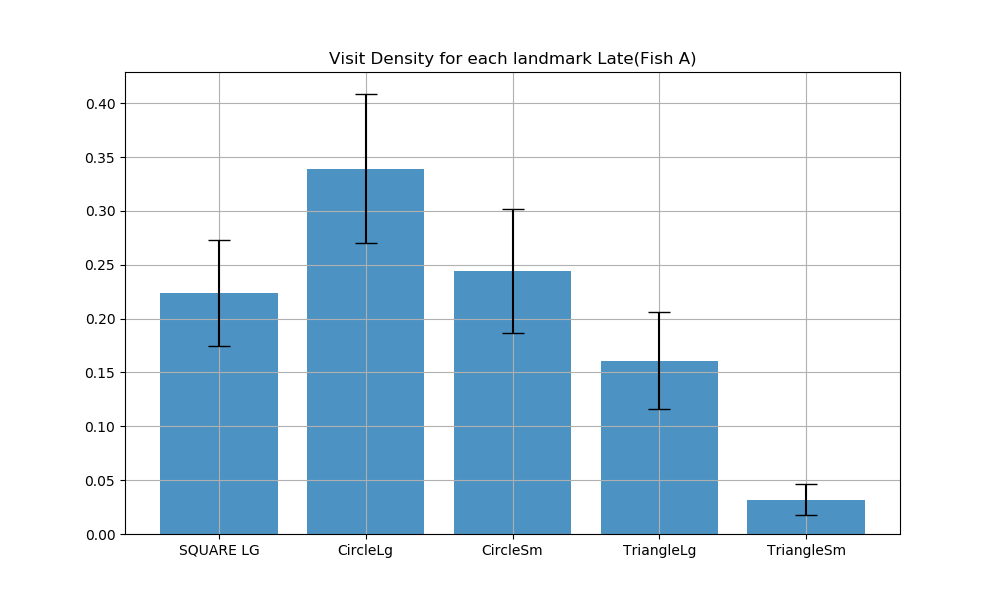

In [120]:
averagesTime_fishA = [ mean_time_square_large_fishA, mean_time_circle_large_fishA, mean_time_circle_small_fishA, mean_time_triangle_large_fishA,mean_time_triangle_small_fishA]#,  meanVD_food_fishA_probe/area_food]
averagesTime_fishA = np.asarray(averagesTime_fishA)
averagesTime_fishA_norm = averagesTime_fishA/averagesTime_fishA.sum()
x_bar_fishA = np.arange(5)
std_error_time_fishA = [std_error_time_square_large_fishA, std_error_time_circle_large_fishA, std_error_time_circle_small_fishA, std_error_time_triangle_large_fishA, std_error_time_triangle_small_fishA]#, stdErrorVD_food_fishA_probe/area_food ]
std_error_time_fishA = np.asarray(std_error_time_fishA)
std_error_time_fishA_norm = std_error_time_fishA/averagesTime_fishA.sum()

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("Visit Density for each landmark Late(Fish A)")
plt.bar(x_bar_fishA, averagesTime_fishA_norm, yerr = std_error_time_fishA_norm  , alpha = 0.8, capsize = 8)
plt.grid()
plt.xticks(x_bar_fishA, ('SQUARE LG', 'CircleLg', 'CircleSm', 'TriangleLg', 'TriangleSm'))#,'Food'))
plt.savefig("Images/TimeXVisit/TimexVisitFishALate.png")

In [125]:
mean_time_square_small_fishB = time_x_visit_square_small_fishB.mean()
mean_time_square_large_fishB = time_x_visit_square_large_fishB.mean()
mean_time_circle_small_fishB = time_x_visit_circle_small_fishB.mean()
mean_time_circle_large_fishB = time_x_visit_circle_large_fishB.mean()
mean_time_triangle_small_fishB = time_x_visit_triangle_small_fishB.mean()
mean_time_triangle_large_fishB = time_x_visit_triangle_large_fishB.mean()
mean_time_food_fishB = time_x_visit_food_fishB.mean()

std_error_time_square_small_fishB = time_x_visit_square_small_fishB.std()/np.sqrt(len(time_x_visit_square_small_fishB))
std_error_time_square_large_fishB = time_x_visit_square_large_fishB.std()/np.sqrt(len(time_x_visit_square_large_fishB))
std_error_time_circle_small_fishB = time_x_visit_circle_small_fishB.std()/np.sqrt(len(time_x_visit_circle_small_fishB))
std_error_time_circle_large_fishB = time_x_visit_circle_large_fishB.std()/np.sqrt(len(time_x_visit_circle_large_fishB))
std_error_time_triangle_small_fishB = time_x_visit_triangle_small_fishB.std()/np.sqrt(len(time_x_visit_triangle_small_fishB))
std_error_time_triangle_large_fishB = time_x_visit_triangle_large_fishB.std()/np.sqrt(len(time_x_visit_triangle_large_fishB))
std_error_time_food_fishB = time_x_visit_food_fishB.std()/np.sqrt(len(time_x_visit_food_fishB))

C:\Users\jamesjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys


<IPython.core.display.Javascript object>


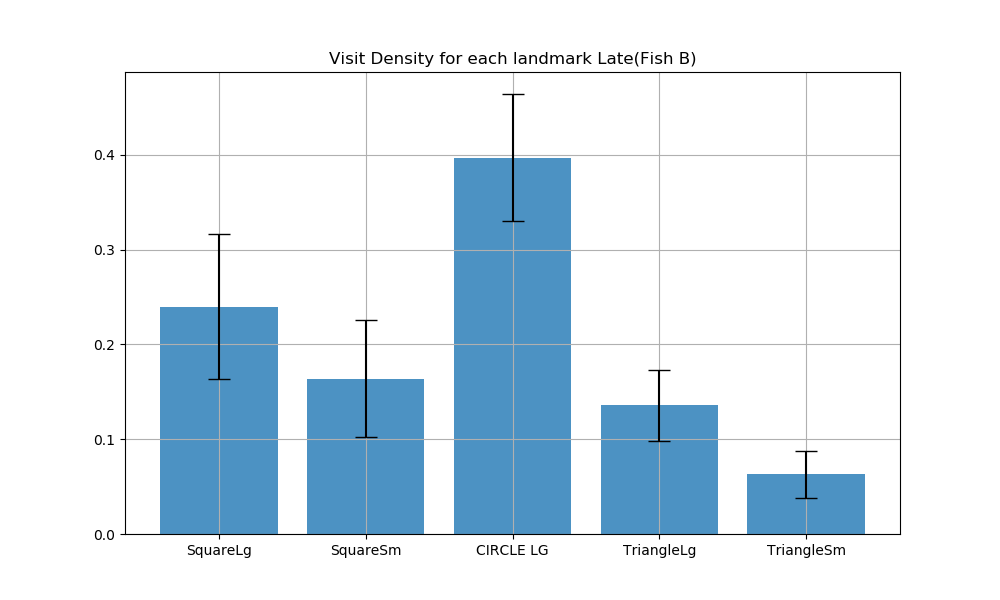

In [126]:
averagesTime_fishB = [ mean_time_square_large_fishB,mean_time_square_small_fishB, mean_time_circle_large_fishB, mean_time_triangle_large_fishB,mean_time_triangle_small_fishB]#,  meanVD_food_fishB_probe/area_food]
averagesTime_fishB = np.asarray(averagesTime_fishB)
averagesTime_fishB_norm = averagesTime_fishB/averagesTime_fishB.sum()
x_bar_fishB = np.arange(5)
std_error_time_fishB = [std_error_time_square_large_fishB, std_error_time_square_small_fishB ,std_error_time_circle_large_fishB, std_error_time_triangle_large_fishB, std_error_time_triangle_small_fishB]#, stdErrorVD_food_fishB_probe/area_food ]
std_error_time_fishB = np.asarray(std_error_time_fishB)
std_error_time_fishB_norm = std_error_time_fishB/averagesTime_fishB.sum()

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("Visit Density for each landmark Late(Fish B)")
plt.bar(x_bar_fishB, averagesTime_fishB_norm, yerr = std_error_time_fishB_norm  , alpha = 0.8, capsize = 8)
plt.grid()
plt.xticks(x_bar_fishB, ('SquareLg', 'SquareSm','CIRCLE LG', 'TriangleLg', 'TriangleSm'))#,'Food'))
plt.savefig("Images/TimeXVisit/TimexVisitfishBLate.png")

In [127]:
1954/60

32.56666666666667